| Model | D2 Score (1.0 is best) | Hamming Loss (0.0 is best) |
| --- | --- | --- |
| Linear Regression | 0.042259356442480356 | 0.8257038134601887 |
| Poisson | 0.01718213058419238 | 0.8379474381969898 |
| MLP | 0.1868561442236938 | 0.7425719410434376 |
| XGB | 0.20439283715724677 | 0.7101302347344615 |
| CNN |  |
| LSTM | -0.01295315306320477 |
| Bi-LSTM |  |
| CNN-LSTM |  |
| CNN using RDM matrix |  |
| ARIMA |  |
| SARIMA |  |
| KNN | 0.05878813127806326 | 0.7807065429306714 |
| SVM | 0.1810280721323666 | 0.7081026280901506 |
| Decision Tree | 0.18571626809750685 | 0.7284566794041956 |
| Random Forest | 0.2165593291016077 | 0.7234656476643531 |
| Extreme Gradient Boosting | 0.217040273556231 | 0.7169149185058099 |
| Voting Ensemble Best Model (SVM, MLP, Extreme Gradient Boosting) | 0.20505511212466743 | 0.7235436325352882 |
| Stacking Ensemble Best Model (SVM, MLP, Extreme Gradient Boosting) | 0.21303686811098443 | 0.7142634328940186 |

## Tasks



1. MLP
2. CNN
3. LSTM
4. Bi-LSTM
5. CNN-LSTM
6. CNN using RDM matrix
7. ARIMA
8. SARIMA
9. KNN
10. SVM
11. Decision Tree
12. Random Forest
13. Extreme Gradient Boosting
14. Ensemble Best Model





- Hyper-Parameters
- Plots
- Optuna
- Plot predictions
- Feature Corelation plot

In [14]:
import pandas as pd
final_results = pd.DataFrame(columns=["Estimator", "Category", "D2 Score", "MSE", "MAE"])
final_results_sub_cat = pd.DataFrame(columns=["Estimator", "Category", "D2 Score", "MSE", "MAE"])

In [15]:
final_results

Empty DataFrame
Columns: [Estimator, Category, D2 Score, MSE, MAE]
Index: []

In [16]:
final_results_sub_cat

Empty DataFrame
Columns: [Estimator, Category, D2 Score, MSE, MAE]
Index: []

## Data

In [17]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, hamming_loss
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import d2_absolute_error_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
import pprint

# set tensorflow to use cpu
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [18]:
df = pd.read_csv("dataset.csv", index_col=0)
print(df.shape)
df.head()

(51290, 17)


Segment  City  State  Country  Market  Region  Category  Sub-Category  \
0        0  2290    703      139       6       6         2             0   
1        1  3518    702        6       0       9         0             5   
2        0   497    820        6       0       9         2            13   
3        2   375    145       47       4       3         2            13   
4        0   857    270      110       1       0         2             6   

      Sales  Quantity  Discount    Profit  Shipping Cost     dtcos     dtsin  \
0  2309.650         7       0.0  762.1845         933.57 -0.870285 -0.492548   
1  3709.395         9       0.1 -288.7650         923.63  0.815028  0.579421   
2  5175.171         9       0.1  919.9710         915.49  0.262962 -0.964806   
3  2892.510         5       0.1  -96.5400         910.16  0.886680  0.462383   
4  2832.960         8       0.0  311.5200         903.04  0.558244 -0.829677   

   dtdiffcos  dtdiffsin  
0  -0.222521   0.974928  
1  -0.222521   0.974928  
2  -0.222521   0.974928  
3  -0.222521   0.974928  
4  -0.222521   0.974928

In [19]:
decoded_sub_cat = [
    'Accessories', 'Appliances', 'Art', 'Binders', 'Bookcases', 'Chairs', 'Copiers',
    'Envelopes', 'Fasteners', 'Furnishings', 'Labels', 'Machines', 'Paper',
    'Phones', 'Storage', 'Supplies', 'Tables'
]

## Target columns:
> Sub-Category, Quantity


In [20]:
x_labels = [
    # 'dtcos', 'dtsin', 'dtdiffcos', 'dtdiffsin', 
    # 'Segment', 
    # 'City', 'State', 'Country', 'Region',
    # 'Market',
    'Category', 'Sub-Category', 
    'Sales', 'Discount', 'Profit', 'Shipping Cost',
    # 'Quantity'
]
x_train, x_test, y_train, y_test = train_test_split(df[x_labels], df['Quantity'], random_state=42)

### Log

In [21]:
# create augmented_data dir clear if exists
if os.path.exists("results_org_data"):
    shutil.rmtree("results_org_data")
os.mkdir("results_org_data")

In [22]:
dt_range = pd.date_range(start='2011-01-01', end='2014-12-31', freq='15D')
dt_range

DatetimeIndex(['2011-01-01', '2011-01-16', '2011-01-31', '2011-02-15',
               '2011-03-02', '2011-03-17', '2011-04-01', '2011-04-16',
               '2011-05-01', '2011-05-16', '2011-05-31', '2011-06-15',
               '2011-06-30', '2011-07-15', '2011-07-30', '2011-08-14',
               '2011-08-29', '2011-09-13', '2011-09-28', '2011-10-13',
               '2011-10-28', '2011-11-12', '2011-11-27', '2011-12-12',
               '2011-12-27', '2012-01-11', '2012-01-26', '2012-02-10',
               '2012-02-25', '2012-03-11', '2012-03-26', '2012-04-10',
               '2012-04-25', '2012-05-10', '2012-05-25', '2012-06-09',
               '2012-06-24', '2012-07-09', '2012-07-24', '2012-08-08',
               '2012-08-23', '2012-09-07', '2012-09-22', '2012-10-07',
               '2012-10-22', '2012-11-06', '2012-11-21', '2012-12-06',
               '2012-12-21', '2013-01-05', '2013-01-20', '2013-02-04',
               '2013-02-19', '2013-03-06', '2013-03-21', '2013-04-05',
      

## Decision Tree

Decision Tree Regressor, a machine learning algorithm used for regression tasks. The model is instantiated with the following hyperparameters: "random_state" is set to 42, ensuring reproducibility of results; "max_depth" is set to 8, which limits the depth of the decision tree to 8 levels, preventing overfitting and controlling the complexity of the model; and "min_samples_split" is set to 5, which specifies the minimum number of samples required to split an internal node during the construction of the tree. This hyperparameter helps control the trade-off between underfitting and overfitting. Overall, this Decision Tree Regressor model aims to capture complex relationships between features while avoiding excessive complexity and overfitting.

In [23]:
tree_model = DecisionTreeRegressor(random_state=42, max_depth=8, min_samples_split=5).fit(x_train, y_train)

print(tree_model.score(x_train, y_train), tree_model.score(x_test, y_test))
final_results.loc[len(final_results)] = [
    "Decision Tree Regressor", 
    "All", 
    d2_absolute_error_score(y_test, tree_model.predict(x_test)),
    mean_squared_error(y_test, tree_model.predict(x_test)), 
    mean_absolute_error(y_test, tree_model.predict(x_test))
]
# plot line chart of actual and predicted quantity in y axis and dt_range in x axis
fig = go.Figure()
fig.add_trace(go.Scatter(x=dt_range, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=dt_range, y=tree_model.predict(x_test), mode='lines', name='Predicted'))
fig.update_layout(title='Decision Tree - All', xaxis_title='Date', yaxis_title='Quantity')
# make dir for decision tree and delete if exists
if os.path.exists("results_org_data/decision_tree_reg"):
    shutil.rmtree("results_org_data/decision_tree_reg")
os.mkdir("results_org_data/decision_tree_reg")
fig.write_html("results_org_data/decision_tree_reg/all.html")
# fig.show()

final_results

0.38794442095978054 0.37282039273577505


Estimator Category  D2 Score       MSE       MAE
0  Decision Tree Regressor      All  0.209207  3.197346  1.322448

In [24]:
# train decision tree for each Sub-Category
for sub_category in df['Sub-Category'].unique():
    this_df = df[df['Sub-Category'] == sub_category]
    this_x_train, this_x_test, this_y_train, this_y_test = train_test_split(this_df[x_labels], this_df['Quantity'], random_state=42)
    this_model = DecisionTreeRegressor(random_state=42, max_depth=8, min_samples_split=5).fit(this_x_train, this_y_train)
    final_results_sub_cat.loc[len(final_results_sub_cat)] = [
        "Decision Tree Regressor",
        decoded_sub_cat[int(sub_category)-1],
        d2_absolute_error_score(this_y_test, this_model.predict(this_x_test)),
        mean_squared_error(this_y_test, this_model.predict(this_x_test)),
        mean_absolute_error(this_y_test, this_model.predict(this_x_test))
    ]
    # plot line chart of actual and predicted quantity in y axis and dt_range in x axis
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dt_range, y=this_y_test, mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=dt_range, y=this_model.predict(this_x_test), mode='lines', name='Predicted'))
    fig.update_layout(title='Decision Tree - ' + decoded_sub_cat[int(sub_category)-1], xaxis_title='Date', yaxis_title='Quantity')
    fig.write_html("results_org_data/decision_tree_reg/" + decoded_sub_cat[int(sub_category)-1] + ".html")
    # fig.show()

final_results_sub_cat

Estimator     Category  D2 Score       MSE       MAE
0   Decision Tree Regressor       Tables  0.197760  3.931450  1.405225
1   Decision Tree Regressor    Bookcases  0.166572  3.896300  1.406834
2   Decision Tree Regressor        Paper  0.253553  3.759862  1.298285
3   Decision Tree Regressor       Chairs  0.431711  2.152475  0.937268
4   Decision Tree Regressor     Supplies  0.167378  3.957430  1.437815
5   Decision Tree Regressor          Art  0.186028  4.385373  1.456999
6   Decision Tree Regressor      Storage  0.317554  2.850184  1.150152
7   Decision Tree Regressor  Accessories  0.137942  3.944965  1.364761
8   Decision Tree Regressor       Labels  0.178273  3.871553  1.336411
9   Decision Tree Regressor      Binders  0.314762  2.846168  1.120472
10  Decision Tree Regressor       Phones  0.258607  3.275733  1.241320
11  Decision Tree Regressor    Fasteners  0.204975  3.802886  1.374501
12  Decision Tree Regressor   Appliances  0.307912  2.891101  1.202226
13  Decision Tree Regressor     Machines  0.329012  3.048100  1.178967
14  Decision Tree Regressor      Copiers  0.241012  3.362959  1.301122
15  Decision Tree Regressor    Envelopes  0.454930  2.082895  0.927971
16  Decision Tree Regressor  Furnishings  0.470476  2.429327  0.970524

In [25]:
from sklearn import tree
import graphviz

tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=x_labels)
graph = graphviz.Source(tree_graph)
graph.format = 'png'
graph.render('results_org_data/decision_tree/tree_graph')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.638186 to fit


'results_org_data/decision_tree/tree_graph.png'

## Poisson

The StandardScaler is a preprocessing step that scales the input features to have zero mean and unit variance. This step helps in standardizing the features and making them comparable, which can improve the performance of certain machine learning algorithms.

The PoissonRegressor is a regression model specifically designed to handle data with a Poisson distribution, where the target variable represents counts or frequencies. It is instantiated with the "max_iter" parameter set to 400, which specifies the maximum number of iterations during the optimization process. The PoissonRegressor aims to predict the target variable based on the input features by assuming a Poisson distribution for the target variable.

By combining these two steps in a pipeline, the input data will first be scaled using StandardScaler, and then the scaled data will be fed into the PoissonRegressor for training and prediction. This pipeline allows for efficient and consistent preprocessing and modeling of the data in a sequential manner.

In [26]:
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

estimator = make_pipeline(StandardScaler(), PoissonRegressor(max_iter=400))
estimator.fit(x_train, y_train)


final_results.loc[len(final_results)] = [
    "Poisson Regression",
    "All",
    d2_absolute_error_score(y_test, estimator.predict(x_test)),
    mean_squared_error(y_test, estimator.predict(x_test)),
    mean_absolute_error(y_test, estimator.predict(x_test))
]
# plot line chart of actual and predicted quantity in y axis and dt_range in x axis
fig = go.Figure()
fig.add_trace(go.Scatter(x=dt_range, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=dt_range, y=estimator.predict(x_test), mode='lines', name='Predicted'))
fig.update_layout(title='Poisson Regression - All', xaxis_title='Date', yaxis_title='Quantity')
# make dir for decision tree and delete if exists
if os.path.exists("results_org_data/poisson_regression"):
    shutil.rmtree("results_org_data/poisson_regression")
os.mkdir("results_org_data/poisson_regression")
fig.write_html("results_org_data/poisson_regression/all.html")
# fig.show()

final_results

Estimator Category  D2 Score       MSE       MAE
0  Decision Tree Regressor      All  0.209207  3.197346  1.322448
1       Poisson Regression      All -0.002348  4.628923  1.676234

In [27]:
# train poisson regression for each Sub-Category
for sub_category in df['Sub-Category'].unique():
    this_df = df[df['Sub-Category'] == sub_category]
    this_x_train, this_x_test, this_y_train, this_y_test = train_test_split(this_df[x_labels], this_df['Quantity'], random_state=42)
    this_model = estimator.fit(this_x_train, this_y_train)
    final_results_sub_cat.loc[len(final_results_sub_cat)] = [
        "Poisson Regression",
        decoded_sub_cat[int(sub_category)-1],
        d2_absolute_error_score(this_y_test, this_model.predict(this_x_test)),
        mean_squared_error(this_y_test, this_model.predict(this_x_test)),
        mean_absolute_error(this_y_test, this_model.predict(this_x_test))
    ]
    # plot line chart of actual and predicted quantity in y axis and dt_range in x axis
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dt_range, y=this_y_test, mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=dt_range, y=this_model.predict(this_x_test), mode='lines', name='Predicted'))
    fig.update_layout(title='Poisson Regression - ' + decoded_sub_cat[int(sub_category)-1], xaxis_title='Date', yaxis_title='Quantity')
    fig.write_html("results_org_data/poisson_regression/" + decoded_sub_cat[int(sub_category)-1] + ".html")
    # fig.show()

final_results_sub_cat

Estimator     Category  D2 Score       MSE       MAE
0   Decision Tree Regressor       Tables  0.197760  3.931450  1.405225
1   Decision Tree Regressor    Bookcases  0.166572  3.896300  1.406834
2   Decision Tree Regressor        Paper  0.253553  3.759862  1.298285
3   Decision Tree Regressor       Chairs  0.431711  2.152475  0.937268
4   Decision Tree Regressor     Supplies  0.167378  3.957430  1.437815
5   Decision Tree Regressor          Art  0.186028  4.385373  1.456999
6   Decision Tree Regressor      Storage  0.317554  2.850184  1.150152
7   Decision Tree Regressor  Accessories  0.137942  3.944965  1.364761
8   Decision Tree Regressor       Labels  0.178273  3.871553  1.336411
9   Decision Tree Regressor      Binders  0.314762  2.846168  1.120472
10  Decision Tree Regressor       Phones  0.258607  3.275733  1.241320
11  Decision Tree Regressor    Fasteners  0.204975  3.802886  1.374501
12  Decision Tree Regressor   Appliances  0.307912  2.891101  1.202226
13  Decision Tree Regressor     Machines  0.329012  3.048100  1.178967
14  Decision Tree Regressor      Copiers  0.241012  3.362959  1.301122
15  Decision Tree Regressor    Envelopes  0.454930  2.082895  0.927971
16  Decision Tree Regressor  Furnishings  0.470476  2.429327  0.970524
17       Poisson Regression       Tables  0.061584  4.925316  1.643754
18       Poisson Regression    Bookcases  0.049098  4.444589  1.605132
19       Poisson Regression        Paper  0.054072  4.720869  1.645240
20       Poisson Regression       Chairs  0.145271  4.228981  1.409688
21       Poisson Regression     Supplies  0.156171  3.647729  1.457168
22       Poisson Regression          Art -0.032311  5.954481  1.847822
23       Poisson Regression      Storage -0.023675  4.916205  1.725238
24       Poisson Regression  Accessories  0.068976  3.530478  1.473945
25       Poisson Regression       Labels  0.053775  3.788765  1.538887
26       Poisson Regression      Binders  0.154917  3.267234  1.381844
27       Poisson Regression       Phones  0.112351  3.902008  1.486198
28       Poisson Regression    Fasteners  0.110158  4.275334  1.538428
29       Poisson Regression   Appliances  0.192161  3.419465  1.403297
30       Poisson Regression     Machines  0.138259  4.156503  1.514133
31       Poisson Regression      Copiers  0.193839  3.251843  1.381991
32       Poisson Regression    Envelopes  0.308101  2.698055  1.177944
33       Poisson Regression  Furnishings  0.127393  4.376123  1.599334

## XGB

This model is an XGBoost regressor, which is specifically designed for regression tasks. It is initialized with the following hyperparameters:

"max_depth" is set to 8, which controls the maximum depth of each tree in the ensemble. It helps control the complexity of the model and prevent overfitting.
"n_estimators" is set to 1000, specifying the number of trees to be built in the ensemble. More trees can improve the model's performance but also increase computation time.
"subsample" is set to 0.8, indicating that each tree is trained on a random subsample of 80% of the training data. This helps in reducing overfitting by introducing randomness in the training process.
"random_state" is set to 42, ensuring reproducibility of results.
In summary, the XGBRegressor with these hyperparameters aims to build an ensemble of gradient boosting trees for regression. It balances model complexity, controls the number of trees, introduces randomness through subsampling, and ensures consistent results across runs.

In [28]:
from xgboost import XGBRegressor
estimator_xgb = XGBRegressor(max_depth=8, n_estimators=1000, subsample=.8, random_state=42)
estimator_xgb.fit(x_train, y_train)

final_results.loc[len(final_results)] = [
    "XGBoost",
    "All",
    d2_absolute_error_score(y_test, estimator_xgb.predict(x_test)),
    mean_squared_error(y_test, estimator_xgb.predict(x_test)),
    mean_absolute_error(y_test, estimator_xgb.predict(x_test))
]
# plot line chart of actual and predicted quantity in y axis and dt_range in x axis
fig = go.Figure()
fig.add_trace(go.Scatter(x=dt_range, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=dt_range, y=estimator_xgb.predict(x_test), mode='lines', name='Predicted'))
fig.update_layout(title='XGBoost - All', xaxis_title='Date', yaxis_title='Quantity')
# make dir for decision tree and delete if exists
if os.path.exists("results_org_data/xgboost"):
    shutil.rmtree("results_org_data/xgboost")
os.mkdir("results_org_data/xgboost")
fig.write_html("results_org_data/xgboost/all.html")
# fig.show()

final_results

Estimator Category  D2 Score       MSE       MAE
0  Decision Tree Regressor      All  0.209207  3.197346  1.322448
1       Poisson Regression      All -0.002348  4.628923  1.676234
2                  XGBoost      All  0.310269  2.782876  1.153442

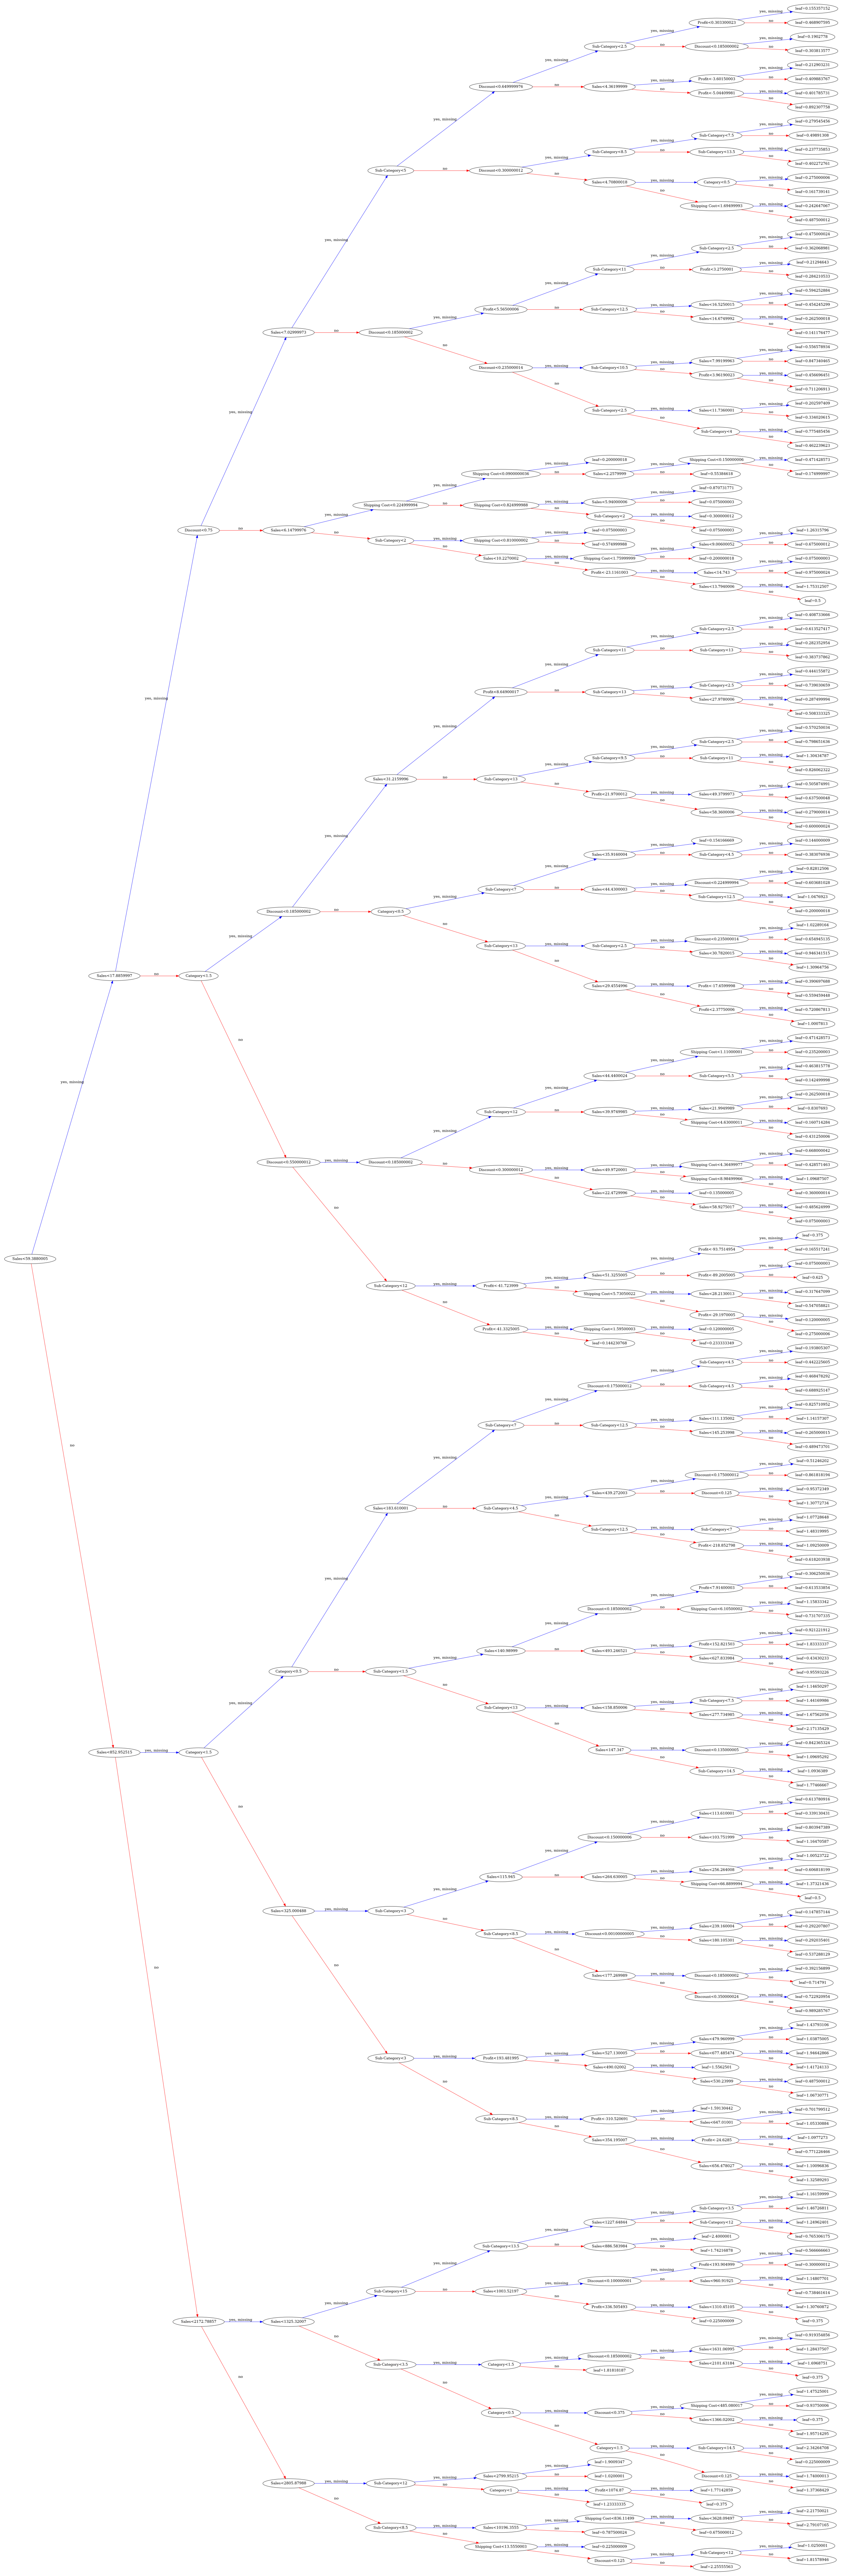

In [29]:
# plot xgb tree
from xgboost import plot_tree
plot_tree(estimator_xgb, num_trees=0, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('results_org_data/xgboost/tree.png')

In [30]:
# train xgboost for each Sub-Category
for sub_category in df['Sub-Category'].unique():
    this_df = df[df['Sub-Category'] == sub_category]
    this_x_train, this_x_test, this_y_train, this_y_test = train_test_split(this_df[x_labels], this_df['Quantity'], random_state=42)
    this_model = estimator_xgb.fit(this_x_train, this_y_train)
    final_results_sub_cat.loc[len(final_results_sub_cat)] = [
        "XGBoost",
        decoded_sub_cat[int(sub_category)-1],
        d2_absolute_error_score(this_y_test, this_model.predict(this_x_test)),
        mean_squared_error(this_y_test, this_model.predict(this_x_test)),
        mean_absolute_error(this_y_test, this_model.predict(this_x_test))
    ]
    # plot line chart of actual and predicted quantity in y axis and dt_range in x axis
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dt_range, y=this_y_test, mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=dt_range, y=this_model.predict(this_x_test), mode='lines', name='Predicted'))
    fig.update_layout(title='XGBoost - ' + decoded_sub_cat[int(sub_category)-1], xaxis_title='Date', yaxis_title='Quantity')
    fig.write_html("results_org_data/xgboost/" + decoded_sub_cat[int(sub_category)-1] + ".html")
    # fig.show()

final_results_sub_cat

Estimator     Category  D2 Score       MSE       MAE
0   Decision Tree Regressor       Tables  0.197760  3.931450  1.405225
1   Decision Tree Regressor    Bookcases  0.166572  3.896300  1.406834
2   Decision Tree Regressor        Paper  0.253553  3.759862  1.298285
3   Decision Tree Regressor       Chairs  0.431711  2.152475  0.937268
4   Decision Tree Regressor     Supplies  0.167378  3.957430  1.437815
5   Decision Tree Regressor          Art  0.186028  4.385373  1.456999
6   Decision Tree Regressor      Storage  0.317554  2.850184  1.150152
7   Decision Tree Regressor  Accessories  0.137942  3.944965  1.364761
8   Decision Tree Regressor       Labels  0.178273  3.871553  1.336411
9   Decision Tree Regressor      Binders  0.314762  2.846168  1.120472
10  Decision Tree Regressor       Phones  0.258607  3.275733  1.241320
11  Decision Tree Regressor    Fasteners  0.204975  3.802886  1.374501
12  Decision Tree Regressor   Appliances  0.307912  2.891101  1.202226
13  Decision Tree Regressor     Machines  0.329012  3.048100  1.178967
14  Decision Tree Regressor      Copiers  0.241012  3.362959  1.301122
15  Decision Tree Regressor    Envelopes  0.454930  2.082895  0.927971
16  Decision Tree Regressor  Furnishings  0.470476  2.429327  0.970524
17       Poisson Regression       Tables  0.061584  4.925316  1.643754
18       Poisson Regression    Bookcases  0.049098  4.444589  1.605132
19       Poisson Regression        Paper  0.054072  4.720869  1.645240
20       Poisson Regression       Chairs  0.145271  4.228981  1.409688
21       Poisson Regression     Supplies  0.156171  3.647729  1.457168
22       Poisson Regression          Art -0.032311  5.954481  1.847822
23       Poisson Regression      Storage -0.023675  4.916205  1.725238
24       Poisson Regression  Accessories  0.068976  3.530478  1.473945
25       Poisson Regression       Labels  0.053775  3.788765  1.538887
26       Poisson Regression      Binders  0.154917  3.267234  1.381844
27       Poisson Regression       Phones  0.112351  3.902008  1.486198
28       Poisson Regression    Fasteners  0.110158  4.275334  1.538428
29       Poisson Regression   Appliances  0.192161  3.419465  1.403297
30       Poisson Regression     Machines  0.138259  4.156503  1.514133
31       Poisson Regression      Copiers  0.193839  3.251843  1.381991
32       Poisson Regression    Envelopes  0.308101  2.698055  1.177944
33       Poisson Regression  Furnishings  0.127393  4.376123  1.599334
34                  XGBoost       Tables  0.199699  4.083713  1.401827
35                  XGBoost    Bookcases  0.208884  3.736739  1.335412
36                  XGBoost        Paper  0.273011  3.773573  1.264441
37                  XGBoost       Chairs  0.483764  1.825256  0.851418
38                  XGBoost     Supplies  0.183925  3.354196  1.409240
39                  XGBoost          Art  0.264397  4.164451  1.316721
40                  XGBoost      Storage  0.373684  2.316830  1.055554
41                  XGBoost  Accessories  0.149693  3.536830  1.346158
42                  XGBoost       Labels  0.229506  3.141314  1.253088
43                  XGBoost      Binders  0.335075  2.703123  1.087257
44                  XGBoost       Phones  0.269684  3.388801  1.222773
45                  XGBoost    Fasteners  0.228146  3.617163  1.334441
46                  XGBoost   Appliances  0.430137  2.281659  0.989910
47                  XGBoost     Machines  0.415280  2.517073  1.027390
48                  XGBoost      Copiers  0.268960  2.894817  1.253212
49                  XGBoost    Envelopes  0.495330  1.714971  0.859190
50                  XGBoost  Furnishings  0.514768  2.009494  0.889343

## MLP

The StandardScaler is a preprocessing step that standardizes the input features by scaling them to have zero mean and unit variance. This helps in normalizing the features and making them comparable, which can improve the performance of certain machine learning algorithms.

The MLPRegressor is a multi-layer perceptron (MLP) model, also known as a neural network, used for regression tasks. It is initialized with the following parameters:

"hidden_layer_sizes" is set to (50,), indicating a single hidden layer with 50 neurons. This controls the architecture of the neural network and the number of hidden units in that layer.
"max_iter" is set to 400, specifying the maximum number of iterations or epochs for which the neural network will be trained.
By combining these two steps in a pipeline, the input data will first be scaled using StandardScaler, and then the scaled data will be fed into the MLPRegressor for training and prediction. This pipeline allows for consistent preprocessing and modeling of the data using a neural network-based regression approach.

In [31]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

estimator = make_pipeline(
    StandardScaler(), 
    MLPRegressor(hidden_layer_sizes=(50,), max_iter=400)
)

estimator.fit(x_train, y_train)

final_results.loc[len(final_results)] = [
    "Neural Network(MLP)",
    "All",
    d2_absolute_error_score(y_test, estimator.predict(x_test)),
    mean_squared_error(y_test, estimator.predict(x_test)),
    mean_absolute_error(y_test, estimator.predict(x_test))
]
# plot line chart of actual and predicted quantity in y axis and dt_range in x axis
fig = go.Figure()
fig.add_trace(go.Scatter(x=dt_range, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=dt_range, y=estimator.predict(x_test), mode='lines', name='Predicted'))
fig.update_layout(title='Neural Network(MLP) - All', xaxis_title='Date', yaxis_title='Quantity')
# make dir for decision tree and delete if exists
if os.path.exists("results_org_data/neural_network_mlp"):
    shutil.rmtree("results_org_data/neural_network_mlp")
os.mkdir("results_org_data/neural_network_mlp")
fig.write_html("results_org_data/neural_network_mlp/all.html")
# fig.show()

final_results

Estimator Category  D2 Score       MSE       MAE
0  Decision Tree Regressor      All  0.209207  3.197346  1.322448
1       Poisson Regression      All -0.002348  4.628923  1.676234
2                  XGBoost      All  0.310269  2.782876  1.153442
3      Neural Network(MLP)      All  0.190696  3.229451  1.353405

In [32]:
# train MLP for each sub-category
for sub_category in df['Sub-Category'].unique():
    this_df = df[df['Sub-Category'] == sub_category]
    this_x_train, this_x_test, this_y_train, this_y_test = train_test_split(this_df[x_labels], this_df['Quantity'], random_state=42)
    this_model = estimator.fit(this_x_train, this_y_train)
    final_results_sub_cat.loc[len(final_results_sub_cat)] = [
        "Neural Network(MLP)",
        decoded_sub_cat[int(sub_category)-1],
        d2_absolute_error_score(this_y_test, this_model.predict(this_x_test)),
        mean_squared_error(this_y_test, this_model.predict(this_x_test)),
        mean_absolute_error(this_y_test, this_model.predict(this_x_test))
    ]
    # plot line chart of actual and predicted quantity in y axis and dt_range in x axis
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dt_range, y=this_y_test, mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=dt_range, y=this_model.predict(this_x_test), mode='lines', name='Predicted'))
    fig.update_layout(title='Neural Network(MLP) - ' + decoded_sub_cat[int(sub_category)-1], xaxis_title='Date', yaxis_title='Quantity')
    fig.write_html("results_org_data/neural_network_mlp/" + decoded_sub_cat[int(sub_category)-1] + ".html")
    # fig.show()
    
final_results_sub_cat

/home/smbh/.venvs/gs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.

/home/smbh/.venvs/gs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.

/home/smbh/.venvs/gs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.

/home/smbh/.venvs/gs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.



Estimator     Category  D2 Score       MSE       MAE
0   Decision Tree Regressor       Tables  0.197760  3.931450  1.405225
1   Decision Tree Regressor    Bookcases  0.166572  3.896300  1.406834
2   Decision Tree Regressor        Paper  0.253553  3.759862  1.298285
3   Decision Tree Regressor       Chairs  0.431711  2.152475  0.937268
4   Decision Tree Regressor     Supplies  0.167378  3.957430  1.437815
..                      ...          ...       ...       ...       ...
63      Neural Network(MLP)   Appliances  0.288832  2.693378  1.235371
64      Neural Network(MLP)     Machines  0.303487  2.691677  1.223817
65      Neural Network(MLP)      Copiers  0.295773  2.533817  1.207246
66      Neural Network(MLP)    Envelopes  0.461742  1.780147  0.916373
67      Neural Network(MLP)  Furnishings  0.500481  1.720717  0.915530

[68 rows x 5 columns]

## LSTM

LSTM (Long Short-Term Memory) model using Keras, a high-level neural network library.

The keras.Sequential() function is used to create a sequential model, which allows for the sequential stacking of different layers.

The first layer added to the model is an LSTM layer with 50 units. The return_sequences parameter is set to False, indicating that the LSTM layer will only return the output of the last time step, rather than the full sequence. The input_shape parameter is set based on the shape of the input data (x_train_lstm), which is expected to have a time dimension (x_train_lstm.shape[1]) and feature dimension (x_train_lstm.shape[2]).

A dropout layer is added with a rate of 0.2, which randomly sets 20% of the input units to 0 during training. This helps prevent overfitting.

Finally, a dense layer with a single unit is added, representing the output layer.

The model is compiled with a mean absolute error (mae) loss function and the Adam optimizer.

The model is then trained using the fit() function. It is trained for 50 epochs with a batch size of 72. The training data (x_train_lstm and y_train) are provided for training, and the validation data (x_test_lstm and y_test) are used to monitor the model's performance during training. The training progress is displayed with a verbosity level of 2, and the data is not shuffled during training.

In [33]:
x_train_lstm = x_train.values.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test_lstm = x_test.values.reshape((x_test.shape[0], 1, x_test.shape[1]))

lstm_model = keras.Sequential()
lstm_model.add(keras.layers.LSTM(50, return_sequences=False, input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2])))
lstm_model.add(keras.layers.Dropout(.2))
lstm_model.add(keras.layers.Dense(1))

lstm_model.compile(loss='mae', optimizer='adam')
history = lstm_model.fit(x_train_lstm, y_train, epochs=50, batch_size=72, validation_data=(x_test_lstm, y_test), verbose=2, shuffle=False)

final_results.loc[len(final_results)] = [
    "LSTM",
    "All",
    d2_absolute_error_score(y_test, lstm_model.predict(x_test_lstm)),
    mean_squared_error(y_test, lstm_model.predict(x_test_lstm)),
    mean_absolute_error(y_test, lstm_model.predict(x_test_lstm))
]
# plot line chart of actual and predicted quantity in y axis and dt_range in x axis
fig = go.Figure()
fig.add_trace(go.Scatter(x=dt_range, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=dt_range, y=lstm_model.predict(x_test_lstm), mode='lines', name='Predicted'))
fig.update_layout(title='LSTM - All', xaxis_title='Date', yaxis_title='Quantity')
# make dir for decision tree and delete if exists
if os.path.exists("results_org_data/lstm"):
    shutil.rmtree("results_org_data/lstm")
os.mkdir("results_org_data/lstm")
fig.write_html("results_org_data/lstm/all.html")
# fig.show()

final_results

2023-07-05 11:29:43.090310: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-05 11:29:43.090347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: dev3
2023-07-05 11:29:43.090352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: dev3
2023-07-05 11:29:43.090451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 495.29.5
2023-07-05 11:29:43.090470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 495.29.5
2023-07-05 11:29:43.090474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 495.29.5
2023-07-05 11:29:43.263617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this

Epoch 1/50


2023-07-05 11:29:43.509734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:29:43.511412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:29:43.512510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

535/535 - 3s - loss: 1.6841 - val_loss: 1.5497 - 3s/epoch - 5ms/step
Epoch 2/50
535/535 - 1s - loss: 1.5810 - val_loss: 1.5303 - 1s/epoch - 2ms/step
Epoch 3/50
535/535 - 1s - loss: 1.5720 - val_loss: 1.5244 - 1s/epoch - 2ms/step
Epoch 4/50
535/535 - 1s - loss: 1.5625 - val_loss: 1.5238 - 1s/epoch - 2ms/step
Epoch 5/50
535/535 - 1s - loss: 1.5646 - val_loss: 1.5212 - 1s/epoch - 2ms/step
Epoch 6/50
535/535 - 1s - loss: 1.5602 - val_loss: 1.5139 - 1s/epoch - 2ms/step
Epoch 7/50
535/535 - 1s - loss: 1.5606 - val_loss: 1.5216 - 1s/epoch - 2ms/step
Epoch 8/50
535/535 - 1s - loss: 1.5558 - val_loss: 1.5090 - 1s/epoch - 2ms/step
Epoch 9/50
535/535 - 1s - loss: 1.5510 - val_loss: 1.5256 - 1s/epoch - 2ms/step
Epoch 10/50
535/535 - 1s - loss: 1.5499 - val_loss: 1.5040 - 1s/epoch - 2ms/step
Epoch 11/50
535/535 - 1s - loss: 1.5380 - val_loss: 1.4970 - 1s/epoch - 2ms/step
Epoch 12/50
535/535 - 1s - loss: 1.5367 - val_loss: 1.4967 - 1s/epoch - 2ms/step
Epoch 13/50
535/535 - 1s - loss: 1.5397 - val_lo

2023-07-05 11:30:37.492921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:30:37.496824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:30:37.497902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

401/401 [==============================] - 0s 812us/step


Estimator Category  D2 Score       MSE       MAE
0  Decision Tree Regressor      All  0.209207  3.197346  1.322448
1       Poisson Regression      All -0.002348  4.628923  1.676234
2                  XGBoost      All  0.310269  2.782876  1.153442
3      Neural Network(MLP)      All  0.190696  3.229451  1.353405
4                     LSTM      All  0.145627  3.985983  1.428775

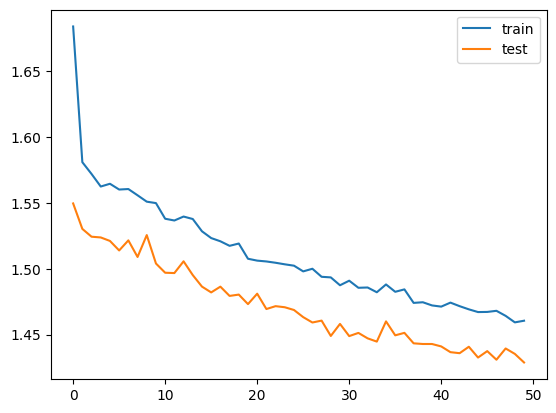

<Figure size 640x480 with 0 Axes>

In [34]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
plt.savefig("results_org_data/lstm/all_loss.png")

In [35]:
# train lstm models for each category
for sub_category in df['Sub-Category'].unique():
    this_df = df[df['Sub-Category'] == sub_category]
    this_x_train, this_x_test, this_y_train, this_y_test = train_test_split(this_df[x_labels], this_df['Quantity'], random_state=42)
    this_x_train_lstm = this_x_train.values.reshape((this_x_train.shape[0], 1, this_x_train.shape[1]))
    this_x_test_lstm = this_x_test.values.reshape((this_x_test.shape[0], 1, this_x_test.shape[1]))
    this_model = keras.Sequential()
    this_model.add(keras.layers.LSTM(50, return_sequences=False, input_shape=(this_x_train_lstm.shape[1], this_x_train_lstm.shape[2])))
    this_model.add(keras.layers.Dropout(.2))
    this_model.add(keras.layers.Dense(1))
    this_model.compile(loss='mae', optimizer='adam')
    history = this_model.fit(this_x_train_lstm, this_y_train, epochs=50, batch_size=72, validation_data=(this_x_test_lstm, this_y_test), verbose=2, shuffle=False)
    final_results_sub_cat.loc[len(final_results_sub_cat)] = [
        "LSTM",
        decoded_sub_cat[int(sub_category)-1],
        d2_absolute_error_score(this_y_test, this_model.predict(this_x_test_lstm)),
        mean_squared_error(this_y_test, this_model.predict(this_x_test_lstm)),
        mean_absolute_error(this_y_test, this_model.predict(this_x_test_lstm))
    ]
    # plot line chart of actual and predicted quantity in y axis and dt_range in x axis
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dt_range, y=this_y_test, mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=dt_range, y=this_model.predict(this_x_test_lstm), mode='lines', name='Predicted'))
    fig.update_layout(title='LSTM - ' + decoded_sub_cat[int(sub_category)-1], xaxis_title='Date', yaxis_title='Quantity')
    fig.write_html("results_org_data/lstm/" + decoded_sub_cat[int(sub_category)-1] + ".html")
    # fig.show()

final_results_sub_cat

Epoch 1/50


2023-07-05 11:30:39.987783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:30:39.989513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:30:39.990468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

33/33 - 2s - loss: 3.2291 - val_loss: 2.5276 - 2s/epoch - 50ms/step
Epoch 2/50


2023-07-05 11:30:41.560744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:30:41.562542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:30:41.563471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

33/33 - 0s - loss: 2.0631 - val_loss: 1.8499 - 94ms/epoch - 3ms/step
Epoch 3/50
33/33 - 0s - loss: 1.7102 - val_loss: 1.6875 - 95ms/epoch - 3ms/step
Epoch 4/50
33/33 - 0s - loss: 1.6382 - val_loss: 1.6237 - 87ms/epoch - 3ms/step
Epoch 5/50
33/33 - 0s - loss: 1.5809 - val_loss: 1.5854 - 87ms/epoch - 3ms/step
Epoch 6/50
33/33 - 0s - loss: 1.5414 - val_loss: 1.5486 - 88ms/epoch - 3ms/step
Epoch 7/50
33/33 - 0s - loss: 1.5297 - val_loss: 1.5348 - 84ms/epoch - 3ms/step
Epoch 8/50
33/33 - 0s - loss: 1.4994 - val_loss: 1.5099 - 83ms/epoch - 3ms/step
Epoch 9/50
33/33 - 0s - loss: 1.5015 - val_loss: 1.4983 - 83ms/epoch - 3ms/step
Epoch 10/50
33/33 - 0s - loss: 1.4744 - val_loss: 1.5074 - 83ms/epoch - 3ms/step
Epoch 11/50
33/33 - 0s - loss: 1.4470 - val_loss: 1.4859 - 81ms/epoch - 2ms/step
Epoch 12/50
33/33 - 0s - loss: 1.4548 - val_loss: 1.4758 - 81ms/epoch - 2ms/step
Epoch 13/50
33/33 - 0s - loss: 1.4558 - val_loss: 1.4669 - 81ms/epoch - 2ms/step
Epoch 14/50
33/33 - 0s - loss: 1.4549 - val_los

2023-07-05 11:30:46.052975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:30:46.054454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:30:46.055322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 0s 837us/step
Epoch 1/50


2023-07-05 11:30:46.554682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:30:46.556263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:30:46.557166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

36/36 - 2s - loss: 3.1629 - val_loss: 2.5487 - 2s/epoch - 46ms/step
Epoch 2/50


2023-07-05 11:30:48.122830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:30:48.124339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:30:48.125284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

36/36 - 0s - loss: 1.9990 - val_loss: 1.6856 - 101ms/epoch - 3ms/step
Epoch 3/50
36/36 - 0s - loss: 1.6410 - val_loss: 1.5915 - 97ms/epoch - 3ms/step
Epoch 4/50
36/36 - 0s - loss: 1.5692 - val_loss: 1.5426 - 89ms/epoch - 2ms/step
Epoch 5/50
36/36 - 0s - loss: 1.5247 - val_loss: 1.5067 - 89ms/epoch - 2ms/step
Epoch 6/50
36/36 - 0s - loss: 1.4888 - val_loss: 1.4816 - 89ms/epoch - 2ms/step
Epoch 7/50
36/36 - 0s - loss: 1.4835 - val_loss: 1.4739 - 90ms/epoch - 3ms/step
Epoch 8/50
36/36 - 0s - loss: 1.4542 - val_loss: 1.4487 - 91ms/epoch - 3ms/step
Epoch 9/50
36/36 - 0s - loss: 1.4510 - val_loss: 1.4406 - 89ms/epoch - 2ms/step
Epoch 10/50
36/36 - 0s - loss: 1.4489 - val_loss: 1.4287 - 90ms/epoch - 3ms/step
Epoch 11/50
36/36 - 0s - loss: 1.4431 - val_loss: 1.4387 - 88ms/epoch - 2ms/step
Epoch 12/50
36/36 - 0s - loss: 1.4358 - val_loss: 1.4332 - 86ms/epoch - 2ms/step
Epoch 13/50
36/36 - 0s - loss: 1.4305 - val_loss: 1.4264 - 88ms/epoch - 2ms/step
Epoch 14/50
36/36 - 0s - loss: 1.4272 - val_lo

2023-07-05 11:30:52.906913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:30:52.908458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:30:52.909451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 0s 841us/step
Epoch 1/50


2023-07-05 11:30:53.415048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:30:53.416200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:30:53.417581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

35/35 - 2s - loss: 2.5790 - val_loss: 2.1741 - 2s/epoch - 47ms/step
Epoch 2/50


2023-07-05 11:30:54.971888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:30:54.973459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:30:54.974423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

35/35 - 0s - loss: 1.8237 - val_loss: 1.7751 - 100ms/epoch - 3ms/step
Epoch 3/50
35/35 - 0s - loss: 1.6542 - val_loss: 1.7002 - 100ms/epoch - 3ms/step
Epoch 4/50
35/35 - 0s - loss: 1.6110 - val_loss: 1.6624 - 94ms/epoch - 3ms/step
Epoch 5/50
35/35 - 0s - loss: 1.5666 - val_loss: 1.6103 - 87ms/epoch - 2ms/step
Epoch 6/50
35/35 - 0s - loss: 1.5357 - val_loss: 1.5761 - 89ms/epoch - 3ms/step
Epoch 7/50
35/35 - 0s - loss: 1.4964 - val_loss: 1.5454 - 87ms/epoch - 2ms/step
Epoch 8/50
35/35 - 0s - loss: 1.4558 - val_loss: 1.5144 - 86ms/epoch - 2ms/step
Epoch 9/50
35/35 - 0s - loss: 1.4421 - val_loss: 1.4983 - 86ms/epoch - 2ms/step
Epoch 10/50
35/35 - 0s - loss: 1.4156 - val_loss: 1.4838 - 86ms/epoch - 2ms/step
Epoch 11/50
35/35 - 0s - loss: 1.4099 - val_loss: 1.4673 - 89ms/epoch - 3ms/step
Epoch 12/50
35/35 - 0s - loss: 1.3943 - val_loss: 1.4623 - 87ms/epoch - 2ms/step
Epoch 13/50
35/35 - 0s - loss: 1.3876 - val_loss: 1.4603 - 88ms/epoch - 3ms/step
Epoch 14/50
35/35 - 0s - loss: 1.3963 - val_l

2023-07-05 11:30:59.610816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:30:59.611969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:30:59.613120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 0s 835us/step
Epoch 1/50


2023-07-05 11:31:00.441942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:00.443441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:00.444731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

24/24 - 2s - loss: 2.5018 - val_loss: 2.0962 - 2s/epoch - 67ms/step
Epoch 2/50


2023-07-05 11:31:01.979798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:01.981106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:01.982385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

24/24 - 0s - loss: 1.8567 - val_loss: 1.7687 - 77ms/epoch - 3ms/step
Epoch 3/50
24/24 - 0s - loss: 1.6683 - val_loss: 1.6921 - 74ms/epoch - 3ms/step
Epoch 4/50
24/24 - 0s - loss: 1.6099 - val_loss: 1.6558 - 75ms/epoch - 3ms/step
Epoch 5/50
24/24 - 0s - loss: 1.5722 - val_loss: 1.6185 - 67ms/epoch - 3ms/step
Epoch 6/50
24/24 - 0s - loss: 1.5335 - val_loss: 1.5801 - 66ms/epoch - 3ms/step
Epoch 7/50
24/24 - 0s - loss: 1.4986 - val_loss: 1.5126 - 64ms/epoch - 3ms/step
Epoch 8/50
24/24 - 0s - loss: 1.4641 - val_loss: 1.4540 - 69ms/epoch - 3ms/step
Epoch 9/50
24/24 - 0s - loss: 1.4065 - val_loss: 1.4054 - 66ms/epoch - 3ms/step
Epoch 10/50
24/24 - 0s - loss: 1.3630 - val_loss: 1.3626 - 65ms/epoch - 3ms/step
Epoch 11/50
24/24 - 0s - loss: 1.3385 - val_loss: 1.3381 - 65ms/epoch - 3ms/step
Epoch 12/50
24/24 - 0s - loss: 1.3165 - val_loss: 1.2954 - 64ms/epoch - 3ms/step
Epoch 13/50
24/24 - 0s - loss: 1.2851 - val_loss: 1.2740 - 65ms/epoch - 3ms/step
Epoch 14/50
24/24 - 0s - loss: 1.2678 - val_los

2023-07-05 11:31:05.582365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:05.583572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:05.584752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

18/18 [==============================] - 0s 929us/step
Epoch 1/50


2023-07-05 11:31:06.053111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:06.054637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:06.055476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 - 2s - loss: 3.1736 - val_loss: 2.9775 - 2s/epoch - 176ms/step
Epoch 2/50
9/9 - 0s - loss: 2.7371 - val_loss: 2.6094 - 38ms/epoch - 4ms/step
Epoch 3/50


2023-07-05 11:31:07.570643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:07.572297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:07.573327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 - 0s - loss: 2.4036 - val_loss: 2.3699 - 38ms/epoch - 4ms/step
Epoch 4/50
9/9 - 0s - loss: 2.2409 - val_loss: 2.1787 - 39ms/epoch - 4ms/step
Epoch 5/50
9/9 - 0s - loss: 2.0356 - val_loss: 2.0357 - 38ms/epoch - 4ms/step
Epoch 6/50
9/9 - 0s - loss: 1.9354 - val_loss: 1.9421 - 37ms/epoch - 4ms/step
Epoch 7/50
9/9 - 0s - loss: 1.8604 - val_loss: 1.8925 - 37ms/epoch - 4ms/step
Epoch 8/50
9/9 - 0s - loss: 1.8328 - val_loss: 1.8438 - 37ms/epoch - 4ms/step
Epoch 9/50
9/9 - 0s - loss: 1.7476 - val_loss: 1.8191 - 37ms/epoch - 4ms/step
Epoch 10/50
9/9 - 0s - loss: 1.7614 - val_loss: 1.8065 - 36ms/epoch - 4ms/step
Epoch 11/50
9/9 - 0s - loss: 1.7368 - val_loss: 1.7885 - 37ms/epoch - 4ms/step
Epoch 12/50
9/9 - 0s - loss: 1.7068 - val_loss: 1.7630 - 36ms/epoch - 4ms/step
Epoch 13/50
9/9 - 0s - loss: 1.6787 - val_loss: 1.7380 - 35ms/epoch - 4ms/step
Epoch 14/50
9/9 - 0s - loss: 1.6804 - val_loss: 1.7239 - 36ms/epoch - 4ms/step
Epoch 15/50
9/9 - 0s - loss: 1.6512 - val_loss: 1.6987 - 35ms/epoch - 

2023-07-05 11:31:09.709816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:09.711268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:09.712314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 1ms/step
Epoch 1/50


2023-07-05 11:31:10.135983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:10.137531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:10.138467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 - 2s - loss: 2.5614 - val_loss: 1.7269 - 2s/epoch - 26ms/step
Epoch 2/50


2023-07-05 11:31:11.759616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:11.761169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:11.762147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 - 0s - loss: 1.5206 - val_loss: 1.5712 - 152ms/epoch - 2ms/step
Epoch 3/50
65/65 - 0s - loss: 1.4723 - val_loss: 1.5503 - 142ms/epoch - 2ms/step
Epoch 4/50
65/65 - 0s - loss: 1.4740 - val_loss: 1.5424 - 147ms/epoch - 2ms/step
Epoch 5/50
65/65 - 0s - loss: 1.4575 - val_loss: 1.5395 - 143ms/epoch - 2ms/step
Epoch 6/50
65/65 - 0s - loss: 1.4544 - val_loss: 1.5376 - 142ms/epoch - 2ms/step
Epoch 7/50
65/65 - 0s - loss: 1.4696 - val_loss: 1.5313 - 142ms/epoch - 2ms/step
Epoch 8/50
65/65 - 0s - loss: 1.4476 - val_loss: 1.5275 - 146ms/epoch - 2ms/step
Epoch 9/50
65/65 - 0s - loss: 1.4331 - val_loss: 1.5259 - 141ms/epoch - 2ms/step
Epoch 10/50
65/65 - 0s - loss: 1.4383 - val_loss: 1.5238 - 142ms/epoch - 2ms/step
Epoch 11/50
65/65 - 0s - loss: 1.4402 - val_loss: 1.5222 - 141ms/epoch - 2ms/step
Epoch 12/50
65/65 - 0s - loss: 1.4340 - val_loss: 1.5223 - 140ms/epoch - 2ms/step
Epoch 13/50
65/65 - 0s - loss: 1.4348 - val_loss: 1.5163 - 141ms/epoch - 2ms/step
Epoch 14/50
65/65 - 0s - loss: 1.43

2023-07-05 11:31:19.149117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:19.150490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:19.151527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

49/49 [==============================] - 0s 780us/step
Epoch 1/50


2023-07-05 11:31:19.747398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:19.748830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:19.749825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 - 2s - loss: 2.3325 - val_loss: 2.0222 - 2s/epoch - 79ms/step
Epoch 2/50


2023-07-05 11:31:21.714338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:21.716168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:21.717214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 - 0s - loss: 1.8142 - val_loss: 1.6442 - 82ms/epoch - 3ms/step
Epoch 3/50
26/26 - 0s - loss: 1.5622 - val_loss: 1.4358 - 77ms/epoch - 3ms/step
Epoch 4/50
26/26 - 0s - loss: 1.4229 - val_loss: 1.3436 - 76ms/epoch - 3ms/step
Epoch 5/50
26/26 - 0s - loss: 1.3468 - val_loss: 1.2820 - 71ms/epoch - 3ms/step
Epoch 6/50
26/26 - 0s - loss: 1.3204 - val_loss: 1.2483 - 70ms/epoch - 3ms/step
Epoch 7/50
26/26 - 0s - loss: 1.3005 - val_loss: 1.2249 - 70ms/epoch - 3ms/step
Epoch 8/50
26/26 - 0s - loss: 1.2662 - val_loss: 1.2074 - 70ms/epoch - 3ms/step
Epoch 9/50
26/26 - 0s - loss: 1.2691 - val_loss: 1.1883 - 71ms/epoch - 3ms/step
Epoch 10/50
26/26 - 0s - loss: 1.2332 - val_loss: 1.1790 - 71ms/epoch - 3ms/step
Epoch 11/50
26/26 - 0s - loss: 1.2529 - val_loss: 1.1505 - 71ms/epoch - 3ms/step
Epoch 12/50
26/26 - 0s - loss: 1.2120 - val_loss: 1.1421 - 73ms/epoch - 3ms/step
Epoch 13/50
26/26 - 0s - loss: 1.2141 - val_loss: 1.1518 - 70ms/epoch - 3ms/step
Epoch 14/50
26/26 - 0s - loss: 1.2012 - val_los

2023-07-05 11:31:25.597869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:25.599533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:25.600400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 0s 950us/step
Epoch 1/50


2023-07-05 11:31:26.088427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:26.089889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:26.090887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 - 2s - loss: 3.4026 - val_loss: 2.9419 - 2s/epoch - 85ms/step
Epoch 2/50


2023-07-05 11:31:27.628704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:27.630304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:27.631162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 - 0s - loss: 2.9087 - val_loss: 2.3258 - 64ms/epoch - 3ms/step
Epoch 3/50
19/19 - 0s - loss: 2.3375 - val_loss: 1.8240 - 62ms/epoch - 3ms/step
Epoch 4/50
19/19 - 0s - loss: 1.8795 - val_loss: 1.6239 - 61ms/epoch - 3ms/step
Epoch 5/50
19/19 - 0s - loss: 1.7311 - val_loss: 1.5853 - 61ms/epoch - 3ms/step
Epoch 6/50
19/19 - 0s - loss: 1.7044 - val_loss: 1.5828 - 58ms/epoch - 3ms/step
Epoch 7/50
19/19 - 0s - loss: 1.6798 - val_loss: 1.5686 - 57ms/epoch - 3ms/step
Epoch 8/50
19/19 - 0s - loss: 1.6724 - val_loss: 1.5809 - 56ms/epoch - 3ms/step
Epoch 9/50
19/19 - 0s - loss: 1.6578 - val_loss: 1.5659 - 57ms/epoch - 3ms/step
Epoch 10/50
19/19 - 0s - loss: 1.6592 - val_loss: 1.5539 - 55ms/epoch - 3ms/step
Epoch 11/50
19/19 - 0s - loss: 1.6522 - val_loss: 1.5518 - 55ms/epoch - 3ms/step
Epoch 12/50
19/19 - 0s - loss: 1.6365 - val_loss: 1.5539 - 57ms/epoch - 3ms/step
Epoch 13/50
19/19 - 0s - loss: 1.6452 - val_loss: 1.5655 - 56ms/epoch - 3ms/step
Epoch 14/50
19/19 - 0s - loss: 1.6547 - val_los

2023-07-05 11:31:30.802207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:30.803670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:30.804601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

14/14 [==============================] - 0s 1ms/step
Epoch 1/50


2023-07-05 11:31:31.252792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:31.254415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:31.255271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 - 2s - loss: 2.4670 - val_loss: 2.0868 - 2s/epoch - 100ms/step
Epoch 2/50
16/16 - 0s - loss: 2.0252 - val_loss: 1.7788 - 57ms/epoch - 4ms/step
Epoch 3/50


2023-07-05 11:31:32.772479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:32.774239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:32.775282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 - 0s - loss: 1.8387 - val_loss: 1.6684 - 59ms/epoch - 4ms/step
Epoch 4/50
16/16 - 0s - loss: 1.7747 - val_loss: 1.6202 - 56ms/epoch - 4ms/step
Epoch 5/50
16/16 - 0s - loss: 1.7198 - val_loss: 1.5871 - 56ms/epoch - 4ms/step
Epoch 6/50
16/16 - 0s - loss: 1.6906 - val_loss: 1.5555 - 56ms/epoch - 3ms/step
Epoch 7/50
16/16 - 0s - loss: 1.6156 - val_loss: 1.5196 - 53ms/epoch - 3ms/step
Epoch 8/50
16/16 - 0s - loss: 1.5877 - val_loss: 1.4902 - 53ms/epoch - 3ms/step
Epoch 9/50
16/16 - 0s - loss: 1.5675 - val_loss: 1.4652 - 52ms/epoch - 3ms/step
Epoch 10/50
16/16 - 0s - loss: 1.5506 - val_loss: 1.4421 - 50ms/epoch - 3ms/step
Epoch 11/50
16/16 - 0s - loss: 1.5173 - val_loss: 1.4258 - 51ms/epoch - 3ms/step
Epoch 12/50
16/16 - 0s - loss: 1.4895 - val_loss: 1.4258 - 51ms/epoch - 3ms/step
Epoch 13/50
16/16 - 0s - loss: 1.4937 - val_loss: 1.4023 - 51ms/epoch - 3ms/step
Epoch 14/50
16/16 - 0s - loss: 1.4588 - val_loss: 1.3876 - 50ms/epoch - 3ms/step
Epoch 15/50
16/16 - 0s - loss: 1.4602 - val_lo

2023-07-05 11:31:35.673393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:35.674853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:35.675976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 0s 904us/step
Epoch 1/50


2023-07-05 11:31:36.118687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:36.120058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:36.120960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 - 2s - loss: 2.7690 - val_loss: 2.1739 - 2s/epoch - 62ms/step
Epoch 2/50


2023-07-05 11:31:37.664338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:37.665554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:37.666750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 - 0s - loss: 2.0677 - val_loss: 1.7639 - 78ms/epoch - 3ms/step
Epoch 3/50
26/26 - 0s - loss: 1.7934 - val_loss: 1.6693 - 78ms/epoch - 3ms/step
Epoch 4/50
26/26 - 0s - loss: 1.7013 - val_loss: 1.6149 - 76ms/epoch - 3ms/step
Epoch 5/50
26/26 - 0s - loss: 1.6539 - val_loss: 1.5733 - 71ms/epoch - 3ms/step
Epoch 6/50
26/26 - 0s - loss: 1.6433 - val_loss: 1.5512 - 71ms/epoch - 3ms/step
Epoch 7/50
26/26 - 0s - loss: 1.5925 - val_loss: 1.5041 - 70ms/epoch - 3ms/step
Epoch 8/50
26/26 - 0s - loss: 1.5477 - val_loss: 1.4478 - 69ms/epoch - 3ms/step
Epoch 9/50
26/26 - 0s - loss: 1.4751 - val_loss: 1.4166 - 69ms/epoch - 3ms/step
Epoch 10/50
26/26 - 0s - loss: 1.4465 - val_loss: 1.3664 - 69ms/epoch - 3ms/step
Epoch 11/50
26/26 - 0s - loss: 1.4248 - val_loss: 1.3335 - 71ms/epoch - 3ms/step
Epoch 12/50
26/26 - 0s - loss: 1.3940 - val_loss: 1.3170 - 72ms/epoch - 3ms/step
Epoch 13/50
26/26 - 0s - loss: 1.3816 - val_loss: 1.2827 - 71ms/epoch - 3ms/step
Epoch 14/50
26/26 - 0s - loss: 1.3665 - val_los

2023-07-05 11:31:41.489680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:41.491168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:41.492119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 0s 907us/step
Epoch 1/50


2023-07-05 11:31:41.965776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:41.966894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:41.968044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

53/53 - 2s - loss: 3.0764 - val_loss: 2.2016 - 2s/epoch - 41ms/step
Epoch 2/50


2023-07-05 11:31:44.057365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:44.058532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:44.059825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

53/53 - 0s - loss: 1.7009 - val_loss: 1.5773 - 143ms/epoch - 3ms/step
Epoch 3/50
53/53 - 0s - loss: 1.5124 - val_loss: 1.5324 - 130ms/epoch - 2ms/step
Epoch 4/50
53/53 - 0s - loss: 1.4816 - val_loss: 1.5124 - 125ms/epoch - 2ms/step
Epoch 5/50
53/53 - 0s - loss: 1.4661 - val_loss: 1.5032 - 125ms/epoch - 2ms/step
Epoch 6/50
53/53 - 0s - loss: 1.4389 - val_loss: 1.4827 - 124ms/epoch - 2ms/step
Epoch 7/50
53/53 - 0s - loss: 1.4457 - val_loss: 1.4805 - 124ms/epoch - 2ms/step
Epoch 8/50
53/53 - 0s - loss: 1.4140 - val_loss: 1.4791 - 123ms/epoch - 2ms/step
Epoch 9/50
53/53 - 0s - loss: 1.4190 - val_loss: 1.4622 - 126ms/epoch - 2ms/step
Epoch 10/50
53/53 - 0s - loss: 1.4176 - val_loss: 1.4540 - 124ms/epoch - 2ms/step
Epoch 11/50
53/53 - 0s - loss: 1.4100 - val_loss: 1.4579 - 123ms/epoch - 2ms/step
Epoch 12/50
53/53 - 0s - loss: 1.3926 - val_loss: 1.4468 - 124ms/epoch - 2ms/step
Epoch 13/50
53/53 - 0s - loss: 1.3985 - val_loss: 1.4419 - 124ms/epoch - 2ms/step
Epoch 14/50
53/53 - 0s - loss: 1.39

2023-07-05 11:31:50.627443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:50.628815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:50.629712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 0s 807us/step
Epoch 1/50


2023-07-05 11:31:51.210976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:51.212033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:51.213192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

34/34 - 2s - loss: 2.8030 - val_loss: 2.3841 - 2s/epoch - 48ms/step
Epoch 2/50


2023-07-05 11:31:52.778326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:52.779531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:52.780861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

34/34 - 0s - loss: 1.9263 - val_loss: 1.8164 - 99ms/epoch - 3ms/step
Epoch 3/50
34/34 - 0s - loss: 1.6547 - val_loss: 1.6558 - 94ms/epoch - 3ms/step
Epoch 4/50
34/34 - 0s - loss: 1.5787 - val_loss: 1.6165 - 87ms/epoch - 3ms/step
Epoch 5/50
34/34 - 0s - loss: 1.5369 - val_loss: 1.5832 - 87ms/epoch - 3ms/step
Epoch 6/50
34/34 - 0s - loss: 1.4961 - val_loss: 1.5490 - 85ms/epoch - 2ms/step
Epoch 7/50
34/34 - 0s - loss: 1.4926 - val_loss: 1.5322 - 84ms/epoch - 2ms/step
Epoch 8/50
34/34 - 0s - loss: 1.4590 - val_loss: 1.5171 - 83ms/epoch - 2ms/step
Epoch 9/50
34/34 - 0s - loss: 1.4734 - val_loss: 1.5021 - 84ms/epoch - 2ms/step
Epoch 10/50
34/34 - 0s - loss: 1.4468 - val_loss: 1.4858 - 84ms/epoch - 2ms/step
Epoch 11/50
34/34 - 0s - loss: 1.4338 - val_loss: 1.4945 - 86ms/epoch - 3ms/step
Epoch 12/50
34/34 - 0s - loss: 1.4258 - val_loss: 1.4750 - 87ms/epoch - 3ms/step
Epoch 13/50
34/34 - 0s - loss: 1.4311 - val_loss: 1.4670 - 83ms/epoch - 2ms/step
Epoch 14/50
34/34 - 0s - loss: 1.4414 - val_los

2023-07-05 11:31:57.397592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:57.399022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:57.399987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 0s 881us/step
Epoch 1/50


2023-07-05 11:31:57.890025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:57.891676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:57.892597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

51/51 - 2s - loss: 3.0071 - val_loss: 1.9470 - 2s/epoch - 33ms/step
Epoch 2/50


2023-07-05 11:31:59.475849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:31:59.477420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:31:59.478313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

51/51 - 0s - loss: 1.6409 - val_loss: 1.5921 - 136ms/epoch - 3ms/step
Epoch 3/50
51/51 - 0s - loss: 1.5352 - val_loss: 1.5155 - 119ms/epoch - 2ms/step
Epoch 4/50
51/51 - 0s - loss: 1.4572 - val_loss: 1.4435 - 123ms/epoch - 2ms/step
Epoch 5/50
51/51 - 0s - loss: 1.4121 - val_loss: 1.3932 - 117ms/epoch - 2ms/step
Epoch 6/50
51/51 - 0s - loss: 1.3759 - val_loss: 1.3466 - 118ms/epoch - 2ms/step
Epoch 7/50
51/51 - 0s - loss: 1.3387 - val_loss: 1.3120 - 116ms/epoch - 2ms/step
Epoch 8/50
51/51 - 0s - loss: 1.3262 - val_loss: 1.2886 - 117ms/epoch - 2ms/step
Epoch 9/50
51/51 - 0s - loss: 1.3235 - val_loss: 1.2806 - 115ms/epoch - 2ms/step
Epoch 10/50
51/51 - 0s - loss: 1.3016 - val_loss: 1.2661 - 113ms/epoch - 2ms/step
Epoch 11/50
51/51 - 0s - loss: 1.2939 - val_loss: 1.2594 - 120ms/epoch - 2ms/step
Epoch 12/50
51/51 - 0s - loss: 1.2889 - val_loss: 1.2481 - 118ms/epoch - 2ms/step
Epoch 13/50
51/51 - 0s - loss: 1.2811 - val_loss: 1.2498 - 118ms/epoch - 2ms/step
Epoch 14/50
51/51 - 0s - loss: 1.27

2023-07-05 11:32:05.608545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:32:05.610163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:32:05.611000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 0s 891us/step
Epoch 1/50


2023-07-05 11:32:06.166326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:32:06.167798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:32:06.168735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

37/37 - 2s - loss: 3.0042 - val_loss: 2.2038 - 2s/epoch - 44ms/step
Epoch 2/50


2023-07-05 11:32:07.722315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:32:07.723882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:32:07.724854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

37/37 - 0s - loss: 1.8191 - val_loss: 1.6763 - 102ms/epoch - 3ms/step
Epoch 3/50
37/37 - 0s - loss: 1.5506 - val_loss: 1.5577 - 98ms/epoch - 3ms/step
Epoch 4/50
37/37 - 0s - loss: 1.4965 - val_loss: 1.5079 - 92ms/epoch - 2ms/step
Epoch 5/50
37/37 - 0s - loss: 1.4495 - val_loss: 1.4706 - 89ms/epoch - 2ms/step
Epoch 6/50
37/37 - 0s - loss: 1.4163 - val_loss: 1.4327 - 91ms/epoch - 2ms/step
Epoch 7/50
37/37 - 0s - loss: 1.3904 - val_loss: 1.3911 - 88ms/epoch - 2ms/step
Epoch 8/50
37/37 - 0s - loss: 1.3412 - val_loss: 1.3620 - 92ms/epoch - 2ms/step
Epoch 9/50
37/37 - 0s - loss: 1.3319 - val_loss: 1.3359 - 89ms/epoch - 2ms/step
Epoch 10/50
37/37 - 0s - loss: 1.3137 - val_loss: 1.3193 - 90ms/epoch - 2ms/step
Epoch 11/50
37/37 - 0s - loss: 1.3047 - val_loss: 1.3034 - 89ms/epoch - 2ms/step
Epoch 12/50
37/37 - 0s - loss: 1.2796 - val_loss: 1.2897 - 90ms/epoch - 2ms/step
Epoch 13/50
37/37 - 0s - loss: 1.2666 - val_loss: 1.2818 - 89ms/epoch - 2ms/step
Epoch 14/50
37/37 - 0s - loss: 1.2724 - val_lo

2023-07-05 11:32:12.546036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:32:12.547631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:32:12.548625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 [==============================] - 0s 884us/step
Epoch 1/50


2023-07-05 11:32:13.058356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:32:13.059866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:32:13.060846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 - 2s - loss: 2.6382 - val_loss: 2.3602 - 2s/epoch - 62ms/step
Epoch 2/50


2023-07-05 11:32:14.597560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:32:14.599289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:32:14.600214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 - 0s - loss: 1.8867 - val_loss: 1.8592 - 83ms/epoch - 3ms/step
Epoch 3/50
26/26 - 0s - loss: 1.6058 - val_loss: 1.6091 - 76ms/epoch - 3ms/step
Epoch 4/50
26/26 - 0s - loss: 1.4801 - val_loss: 1.5020 - 76ms/epoch - 3ms/step
Epoch 5/50
26/26 - 0s - loss: 1.3960 - val_loss: 1.4345 - 70ms/epoch - 3ms/step
Epoch 6/50
26/26 - 0s - loss: 1.3434 - val_loss: 1.3905 - 67ms/epoch - 3ms/step
Epoch 7/50
26/26 - 0s - loss: 1.3100 - val_loss: 1.3733 - 70ms/epoch - 3ms/step
Epoch 8/50
26/26 - 0s - loss: 1.3007 - val_loss: 1.3542 - 71ms/epoch - 3ms/step
Epoch 9/50
26/26 - 0s - loss: 1.2748 - val_loss: 1.3314 - 69ms/epoch - 3ms/step
Epoch 10/50
26/26 - 0s - loss: 1.2423 - val_loss: 1.3065 - 70ms/epoch - 3ms/step
Epoch 11/50
26/26 - 0s - loss: 1.2531 - val_loss: 1.2922 - 70ms/epoch - 3ms/step
Epoch 12/50
26/26 - 0s - loss: 1.2351 - val_loss: 1.2804 - 72ms/epoch - 3ms/step
Epoch 13/50
26/26 - 0s - loss: 1.2243 - val_loss: 1.2718 - 70ms/epoch - 3ms/step
Epoch 14/50
26/26 - 0s - loss: 1.2153 - val_los

2023-07-05 11:32:18.392158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:32:18.393696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:32:18.394606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

20/20 [==============================] - 0s 882us/step
Epoch 1/50


2023-07-05 11:32:19.346469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:32:19.348186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:32:19.349247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 - 2s - loss: 2.9622 - val_loss: 2.5660 - 2s/epoch - 64ms/step
Epoch 2/50


2023-07-05 11:32:20.928128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:32:20.929969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:32:20.930812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 - 0s - loss: 2.0241 - val_loss: 1.7562 - 79ms/epoch - 3ms/step
Epoch 3/50
26/26 - 0s - loss: 1.5601 - val_loss: 1.5163 - 79ms/epoch - 3ms/step
Epoch 4/50
26/26 - 0s - loss: 1.3914 - val_loss: 1.3651 - 76ms/epoch - 3ms/step
Epoch 5/50
26/26 - 0s - loss: 1.2561 - val_loss: 1.2198 - 72ms/epoch - 3ms/step
Epoch 6/50
26/26 - 0s - loss: 1.1538 - val_loss: 1.1323 - 72ms/epoch - 3ms/step
Epoch 7/50
26/26 - 0s - loss: 1.1046 - val_loss: 1.0807 - 71ms/epoch - 3ms/step
Epoch 8/50
26/26 - 0s - loss: 1.0588 - val_loss: 1.0448 - 72ms/epoch - 3ms/step
Epoch 9/50
26/26 - 0s - loss: 1.0232 - val_loss: 1.0282 - 73ms/epoch - 3ms/step
Epoch 10/50
26/26 - 0s - loss: 1.0127 - val_loss: 1.0229 - 71ms/epoch - 3ms/step
Epoch 11/50
26/26 - 0s - loss: 1.0019 - val_loss: 1.0109 - 70ms/epoch - 3ms/step
Epoch 12/50
26/26 - 0s - loss: 0.9981 - val_loss: 0.9895 - 68ms/epoch - 3ms/step
Epoch 13/50
26/26 - 0s - loss: 0.9980 - val_loss: 0.9915 - 71ms/epoch - 3ms/step
Epoch 14/50
26/26 - 0s - loss: 0.9791 - val_los

2023-07-05 11:32:24.790733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:32:24.792265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:32:24.793409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 0s 911us/step
Epoch 1/50


2023-07-05 11:32:25.257812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:32:25.259285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:32:25.260258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 - 2s - loss: 2.7498 - val_loss: 2.2512 - 2s/epoch - 58ms/step
Epoch 2/50


2023-07-05 11:32:26.806277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:32:26.808019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:32:26.808934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 - 0s - loss: 1.9069 - val_loss: 1.7175 - 86ms/epoch - 3ms/step
Epoch 3/50
28/28 - 0s - loss: 1.4692 - val_loss: 1.3551 - 84ms/epoch - 3ms/step
Epoch 4/50
28/28 - 0s - loss: 1.2300 - val_loss: 1.1489 - 79ms/epoch - 3ms/step
Epoch 5/50
28/28 - 0s - loss: 1.1418 - val_loss: 1.0739 - 75ms/epoch - 3ms/step
Epoch 6/50
28/28 - 0s - loss: 1.0905 - val_loss: 1.0267 - 74ms/epoch - 3ms/step
Epoch 7/50
28/28 - 0s - loss: 1.0532 - val_loss: 0.9974 - 75ms/epoch - 3ms/step
Epoch 8/50
28/28 - 0s - loss: 1.0467 - val_loss: 0.9728 - 77ms/epoch - 3ms/step
Epoch 9/50
28/28 - 0s - loss: 1.0344 - val_loss: 0.9578 - 74ms/epoch - 3ms/step
Epoch 10/50
28/28 - 0s - loss: 1.0129 - val_loss: 0.9548 - 73ms/epoch - 3ms/step
Epoch 11/50
28/28 - 0s - loss: 1.0238 - val_loss: 0.9406 - 75ms/epoch - 3ms/step
Epoch 12/50
28/28 - 0s - loss: 1.0012 - val_loss: 0.9305 - 73ms/epoch - 3ms/step
Epoch 13/50
28/28 - 0s - loss: 0.9818 - val_loss: 0.9292 - 72ms/epoch - 3ms/step
Epoch 14/50
28/28 - 0s - loss: 0.9720 - val_los

2023-07-05 11:32:30.821071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:32:30.822494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:32:30.823541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - 0s 927us/step


Estimator     Category  D2 Score       MSE       MAE
0   Decision Tree Regressor       Tables  0.197760  3.931450  1.405225
1   Decision Tree Regressor    Bookcases  0.166572  3.896300  1.406834
2   Decision Tree Regressor        Paper  0.253553  3.759862  1.298285
3   Decision Tree Regressor       Chairs  0.431711  2.152475  0.937268
4   Decision Tree Regressor     Supplies  0.167378  3.957430  1.437815
..                      ...          ...       ...       ...       ...
80                     LSTM   Appliances  0.307912  2.918342  1.202227
81                     LSTM     Machines  0.310611  2.983324  1.211299
82                     LSTM      Copiers  0.300719  2.765718  1.198768
83                     LSTM    Envelopes  0.472455  2.033277  0.898135
84                     LSTM  Furnishings  0.504142  1.868089  0.908820

[85 rows x 5 columns]

### RNN

Training Recurrent Neural Networks (RNNs), such as Long Short-Term Memory (LSTM) models, on small datasets can be challenging due to a few reasons:

1. **Data Insufficiency**: LSTMs are powerful tools capable of learning complex patterns, but they often need a lot of data to do so effectively. If you have a small dataset, your model may not have enough examples to learn from, which can lead to overfitting or underfitting.

2. **Long Training Times**: LSTMs can be slow to train. This is due to the sequential nature of the data they process, which inhibits parallel computation to a large extent. Training on a small dataset might not be a problem in terms of computational resources, but if the model overfits, you're still wasting resources on a model that might not perform well.

3. **Complexity of the Model**: LSTMs are inherently complex models with many parameters. If you have a small dataset, it can be challenging to estimate these parameters accurately. The model may end up memorizing the training data (overfitting) instead of learning the underlying patterns.

4. **Vanishing/Exploding Gradients**: LSTMs, like other RNNs, are susceptible to vanishing or exploding gradients, which can hinder learning and make training even more difficult.


Handling multiple categories or sequences in a single LSTM model can be challenging. LSTM models, as well as other recurrent networks, are usually designed to handle a single sequence at a time. This is particularly problematic when dealing with data that can be split into multiple distinct categories or sub-categories, each with its own potentially unique characteristics and patterns.

For example, in a retail scenario, different categories of products (electronics, clothing, food, etc.) might exhibit different sales patterns. Some may be seasonal, while others are more consistent throughout the year. Some categories might be influenced by certain events or holidays, while others are not.

This inherent difficulty of handling multiple sequences can lead to a few potential issues:

1. **Increased Complexity**: If you decide to train a separate LSTM for each category, this can significantly increase the complexity of your overall solution, requiring more computational resources, more time to train, and more effort to maintain and monitor.

2. **Data Sparsity**: Some categories may have fewer data points than others. If you're training separate models, those with less data could perform poorly due to underfitting or overfitting.

However, there are some potential solutions:

1. **Multi-task Learning**: This approach involves modifying the network architecture to handle multiple tasks (or categories) simultaneously. It can improve performance and efficiency by sharing representations across tasks. However, it requires careful design and increases model complexity.

2. **Sequence-to-sequence Models with Attention**: These models can learn to pay "attention" to different parts of the input sequence when predicting each part of the output sequence, which can be beneficial when dealing with multiple categories.

3. **Data Augmentation**: If data sparsity is a concern, techniques like bootstrapping or synthetic data generation can be used to increase the number of data points for each category.

4. **Hierarchical Modeling**: A high-level model could first classify the sequence into a category, and then a category-specific model could be used for the actual prediction.

In any case, whether or not to use separate models for each category should be a decision based on the specifics of your data, the complexity of the patterns you are trying to model, and the resources available for model training and maintenance.

## Bi-LSTM

## CNN-LSTM

## CNN (RDM)

In [36]:
# groups = df.sort_values('Order Date').groupby('Category')
# for g in groups:
#   print(g[1].head())
#   break

RDM (for CNN for points neighborhood)

A Representational Dissimilarity Matrix (RDM) is a technique used in neuroscience and machine learning to compare and visualize the dissimilarity of patterns of activity elicited by different stimuli or tasks. This matrix is essentially a square, symmetric matrix where each element represents the dissimilarity between the responses to a pair of stimuli or tasks.

While this technique can be useful in certain contexts, it might not be the optimal solution for your case due to a few reasons:

1. **No Time-Series Component**: RDMs are generally not designed to handle sequential data with temporal dependencies. They are more commonly used for comparing patterns in static response data.

2. **Lack of Fixed-Length Historical Data**: We don't have historical data with a fixed length, it might be challenging to apply the RDM approach, especially if the patterns you're trying to capture are time-dependent.

3. **Data Sparsity**: In the context of sparse data, constructing an RDM might become more challenging. Many dissimilarity measures (like correlation-based measures, for example) could be less reliable when calculated on sparse data.


## ARIMA

ARIMA (Autoregressive Integrated Moving Average) and SARIMA (Seasonal Autoregressive Integrated Moving Average) are popular methods for time series forecasting. They can be powerful tools when your data exhibits temporal dependencies. 

The decision to use ARIMA or SARIMA depends on the nature of your data. Here are some points to consider:

1. **Trend and Seasonality**: ARIMA is best suited for data that exhibit a clear trend or cyclic behavior but lack a seasonal component. SARIMA, on the other hand, can handle both trend and seasonality. If your data exhibits seasonal patterns (e.g., higher sales during certain months or days of the week), SARIMA would be more appropriate.

2. **Stationarity**: Both ARIMA and SARIMA models require the data to be stationary, i.e., the statistical properties like mean, variance, etc., should be constant over time. If your data is non-stationary, you would need to transform it (e.g., via differencing) to make it stationary before using these models.

3. **Size of the Dataset**: ARIMA and SARIMA can work reasonably well even with smaller datasets, as they primarily model temporal dependencies rather than learning from a large number of examples like deep learning models.

4. **Interpretability**: These models are more interpretable than complex models like LSTMs. They provide specific parameters that relate to the trend and seasonality in the data, which can be useful for understanding the underlying patterns.

However, keep in mind that ARIMA and SARIMA are linear models, and they may not capture complex nonlinear relationships in your data as effectively as some other models. Also, they do not inherently handle multiple different time series (e.g., different categories of products), so you may need to train separate models for each category or use a variant like Vector Autoregression (VAR) if there are interdependencies.

Before deciding on a model, it would be best to visualize your data, check for trends and seasonality, test for stationarity, and consider any business-specific factors. As always, it's a good idea to try multiple approaches and validate them using a hold-out set or cross-validation to see which one performs best.

## SARIMA

## KNN

K-Nearest Neighbors (KNN) regressor model, which is a non-parametric algorithm used for regression tasks. It is initialized with the following hyperparameters:

"n_neighbors" is set to 8, indicating that the model will consider the 8 nearest neighbors to make predictions.
"n_jobs" is set to -1, which enables parallel computation using all available processors. This can speed up the training and prediction process.
The KNN regressor works by finding the K nearest neighbors in the training data for each test instance and predicting the target value based on the average or weighted average of the target values of those neighbors.

In summary, this KNeighborsRegressor model with the specified hyperparameters aims to find the 8 nearest neighbors to make predictions for regression tasks. It can take advantage of parallel computation for faster execution.

In [37]:
from sklearn.neighbors import KNeighborsRegressor
estimator = KNeighborsRegressor(n_neighbors=8, n_jobs=-1)
estimator.fit(x_train, y_train)

final_results.loc[len(final_results)] = [
    "KNN",
    "All",
    d2_absolute_error_score(y_test, estimator.predict(x_test)),
    mean_squared_error(y_test, estimator.predict(x_test)),
    mean_absolute_error(y_test, estimator.predict(x_test))
]
# plot line chart of actual and predicted quantity in y axis and dt_range in x axis
fig = go.Figure()
fig.add_trace(go.Scatter(x=dt_range, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=dt_range, y=estimator.predict(x_test), mode='lines', name='Predicted'))
fig.update_layout(title='KNN - All', xaxis_title='Date', yaxis_title='Quantity')
# make dir for decision tree and delete if exists
if os.path.exists("results_org_data/knn"):
    shutil.rmtree("results_org_data/knn")
os.mkdir("results_org_data/knn")
fig.write_html("results_org_data/knn/all.html")
# fig.show()

final_results

Estimator Category  D2 Score       MSE       MAE
0  Decision Tree Regressor      All  0.209207  3.197346  1.322448
1       Poisson Regression      All -0.002348  4.628923  1.676234
2                  XGBoost      All  0.310269  2.782876  1.153442
3      Neural Network(MLP)      All  0.190696  3.229451  1.353405
4                     LSTM      All  0.145627  3.985983  1.428775
5                      KNN      All  0.078029  4.325155  1.541819

In [38]:
# train KNN models for each sub-category
for sub_category in df['Sub-Category'].unique():
    this_df = df[df['Sub-Category'] == sub_category]
    this_x_train, this_x_test, this_y_train, this_y_test = train_test_split(this_df[x_labels], this_df['Quantity'], random_state=42)
    this_model = estimator.fit(this_x_train, this_y_train)
    final_results_sub_cat.loc[len(final_results_sub_cat)] = [
        "KNN",
        decoded_sub_cat[int(sub_category)-1],
        d2_absolute_error_score(this_y_test, this_model.predict(this_x_test)),
        mean_squared_error(this_y_test, this_model.predict(this_x_test)),
        mean_absolute_error(this_y_test, this_model.predict(this_x_test))
    ]
    # plot line chart of actual and predicted quantity in y axis and dt_range in x axis
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dt_range, y=this_y_test, mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=dt_range, y=this_model.predict(this_x_test), mode='lines', name='Predicted'))
    fig.update_layout(title='KNN - ' + decoded_sub_cat[int(sub_category)-1], xaxis_title='Date', yaxis_title='Quantity')
    fig.write_html("results_org_data/knn/" + decoded_sub_cat[int(sub_category)-1] + ".html")
    # fig.show()

final_results_sub_cat

Estimator     Category  D2 Score       MSE       MAE
0    Decision Tree Regressor       Tables  0.197760  3.931450  1.405225
1    Decision Tree Regressor    Bookcases  0.166572  3.896300  1.406834
2    Decision Tree Regressor        Paper  0.253553  3.759862  1.298285
3    Decision Tree Regressor       Chairs  0.431711  2.152475  0.937268
4    Decision Tree Regressor     Supplies  0.167378  3.957430  1.437815
..                       ...          ...       ...       ...       ...
97                       KNN   Appliances  0.332037  2.666743  1.160319
98                       KNN     Machines  0.299035  2.996645  1.231638
99                       KNN      Copiers  0.266882  2.792308  1.256773
100                      KNN    Envelopes  0.439927  2.022650  0.953512
101                      KNN  Furnishings  0.466841  2.022311  0.977186

[102 rows x 5 columns]

## SVM

The StandardScaler is a preprocessing step that scales the input features to have zero mean and unit variance. This step helps in standardizing the features and making them comparable, which can improve the performance of certain machine learning algorithms.

SVR stands for Support Vector Regressor, which is a type of Support Vector Machine (SVM) algorithm used for regression tasks. It is a powerful algorithm that can handle non-linear regression problems by mapping the data into a higher-dimensional space and finding the best hyperplane to fit the data.

By combining these two steps in a pipeline, the input data will first be scaled using StandardScaler, and then the scaled data will be fed into the SVR for training and prediction. This pipeline allows for consistent preprocessing and modeling of the data using the SVR algorithm.

In [39]:
from sklearn.svm import SVR

estimator = make_pipeline(StandardScaler(), SVR())
estimator.fit(x_train, y_train)

final_results.loc[len(final_results)] = [
    "SVM",
    "All",
    d2_absolute_error_score(y_test, estimator.predict(x_test)),
    mean_squared_error(y_test, estimator.predict(x_test)),
    mean_absolute_error(y_test, estimator.predict(x_test))
]
# plot line chart of actual and predicted quantity in y axis and dt_range in x axis
fig = go.Figure()
fig.add_trace(go.Scatter(x=dt_range, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=dt_range, y=estimator.predict(x_test), mode='lines', name='Predicted'))
fig.update_layout(title='SVM - All', xaxis_title='Date', yaxis_title='Quantity')
# make dir for decision tree and delete if exists
if os.path.exists("results_org_data/svm"):
    shutil.rmtree("results_org_data/svm")
os.mkdir("results_org_data/svm")
fig.write_html("results_org_data/svm/all.html")
# fig.show()

final_results

Estimator Category  D2 Score       MSE       MAE
0  Decision Tree Regressor      All  0.209207  3.197346  1.322448
1       Poisson Regression      All -0.002348  4.628923  1.676234
2                  XGBoost      All  0.310269  2.782876  1.153442
3      Neural Network(MLP)      All  0.190696  3.229451  1.353405
4                     LSTM      All  0.145627  3.985983  1.428775
5                      KNN      All  0.078029  4.325155  1.541819
6                      SVM      All  0.200431  3.533555  1.337125

In [40]:
# train SVM models for each sub-category
for sub_category in df['Sub-Category'].unique():
    this_df = df[df['Sub-Category'] == sub_category]
    this_x_train, this_x_test, this_y_train, this_y_test = train_test_split(this_df[x_labels], this_df['Quantity'], random_state=42)
    this_model = estimator.fit(this_x_train, this_y_train)
    final_results_sub_cat.loc[len(final_results_sub_cat)] = [
        "SVM",
        decoded_sub_cat[int(sub_category)-1],
        d2_absolute_error_score(this_y_test, this_model.predict(this_x_test)),
        mean_squared_error(this_y_test, this_model.predict(this_x_test)),
        mean_absolute_error(this_y_test, this_model.predict(this_x_test))
    ]
    # plot line chart of actual and predicted quantity in y axis and dt_range in x axis
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dt_range, y=this_y_test, mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=dt_range, y=this_model.predict(this_x_test), mode='lines', name='Predicted'))
    fig.update_layout(title='SVM - ' + decoded_sub_cat[int(sub_category)-1], xaxis_title='Date', yaxis_title='Quantity')
    fig.write_html("results_org_data/svm/" + decoded_sub_cat[int(sub_category)-1] + ".html")
    # fig.show()
    
final_results_sub_cat

Estimator     Category  D2 Score       MSE       MAE
0    Decision Tree Regressor       Tables  0.197760  3.931450  1.405225
1    Decision Tree Regressor    Bookcases  0.166572  3.896300  1.406834
2    Decision Tree Regressor        Paper  0.253553  3.759862  1.298285
3    Decision Tree Regressor       Chairs  0.431711  2.152475  0.937268
4    Decision Tree Regressor     Supplies  0.167378  3.957430  1.437815
..                       ...          ...       ...       ...       ...
114                      SVM   Appliances  0.318259  2.944027  1.184254
115                      SVM     Machines  0.286901  3.015858  1.252960
116                      SVM      Copiers  0.294848  2.789342  1.208833
117                      SVM    Envelopes  0.472670  1.984667  0.897768
118                      SVM  Furnishings  0.522526  1.837525  0.875124

[119 rows x 5 columns]

## Linear Regression

The StandardScaler is a preprocessing step that standardizes the input features by scaling them to have zero mean and unit variance. This step helps in normalizing the features and making them comparable, which can improve the performance of certain machine learning algorithms.

LinearRegression is a linear model that assumes a linear relationship between the input features and the target variable. It aims to find the best-fit line that minimizes the sum of the squared differences between the predicted and actual target values.

By combining these two steps in a pipeline, the input data will first be scaled using StandardScaler, and then the scaled data will be fed into the LinearRegression model for training and prediction. This pipeline allows for consistent preprocessing and modeling of the data using a linear regression approach.

In [41]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline

estimator = make_pipeline(
    StandardScaler(),
    LinearRegression())
estimator.fit(x_train, y_train)

final_results.loc[len(final_results)] = [
    "Linear Regression",
    "All",
    d2_absolute_error_score(y_test, estimator.predict(x_test)),
    mean_squared_error(y_test, estimator.predict(x_test)),
    mean_absolute_error(y_test, estimator.predict(x_test))
]
# plot line chart of actual and predicted quantity in y axis and dt_range in x axis
fig = go.Figure()
fig.add_trace(go.Scatter(x=dt_range, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=dt_range, y=estimator.predict(x_test), mode='lines', name='Predicted'))
fig.update_layout(title='Linear Regression - All', xaxis_title='Date', yaxis_title='Quantity')
# make dir for decision tree and delete if exists
if os.path.exists("results_org_data/linear_regression"):
    shutil.rmtree("results_org_data/linear_regression")
os.mkdir("results_org_data/linear_regression")
fig.write_html("results_org_data/linear_regression/all.html")
# fig.show()

final_results

Estimator Category  D2 Score       MSE       MAE
0  Decision Tree Regressor      All  0.209207  3.197346  1.322448
1       Poisson Regression      All -0.002348  4.628923  1.676234
2                  XGBoost      All  0.310269  2.782876  1.153442
3      Neural Network(MLP)      All  0.190696  3.229451  1.353405
4                     LSTM      All  0.145627  3.985983  1.428775
5                      KNN      All  0.078029  4.325155  1.541819
6                      SVM      All  0.200431  3.533555  1.337125
7        Linear Regression      All  0.022118  4.464350  1.635320

In [42]:
# from sklearn.decomposition import PCA, KernelPCA

# estimator = make_pipeline(
#     StandardScaler(),
#     KernelPCA(3, kernel='rbf'), #'linear', 'poly', 'rbf', 'sigmoid', 'cosine'
#     LinearRegression())
# estimator.fit(x_train, y_train)

# final_results.loc[len(final_results)] = [
#     "Linear Regression(Kernel PCA)",
#     "All",
#     d2_absolute_error_score(y_test, estimator.predict(x_test)),
#     mean_squared_error(y_test, estimator.predict(x_test)),
#     mean_absolute_error(y_test, estimator.predict(x_test))
# ]
# final_results

In [43]:
# train Linear Regression models for each sub-category
estimator = make_pipeline(
    StandardScaler(),
    LinearRegression()
)
for sub_category in df['Sub-Category'].unique():
    this_df = df[df['Sub-Category'] == sub_category]
    this_x_train, this_x_test, this_y_train, this_y_test = train_test_split(this_df[x_labels], this_df['Quantity'], random_state=42)
    this_model = estimator.fit(this_x_train, this_y_train)
    final_results_sub_cat.loc[len(final_results_sub_cat)] = [
        "Linear Regression",
        decoded_sub_cat[int(sub_category)-1],
        d2_absolute_error_score(this_y_test, this_model.predict(this_x_test)),
        mean_squared_error(this_y_test, this_model.predict(this_x_test)),
        mean_absolute_error(this_y_test, this_model.predict(this_x_test))
    ]
    # plot line chart of actual and predicted quantity in y axis and dt_range in x axis
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dt_range, y=this_y_test, mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=dt_range, y=this_model.predict(this_x_test), mode='lines', name='Predicted'))
    fig.update_layout(title='Linear Regression - ' + decoded_sub_cat[int(sub_category)-1], xaxis_title='Date', yaxis_title='Quantity')
    fig.write_html("results_org_data/linear_regression/" + decoded_sub_cat[int(sub_category)-1] + ".html")
    # fig.show()
    
final_results_sub_cat

Estimator     Category  D2 Score       MSE       MAE
0    Decision Tree Regressor       Tables  0.197760  3.931450  1.405225
1    Decision Tree Regressor    Bookcases  0.166572  3.896300  1.406834
2    Decision Tree Regressor        Paper  0.253553  3.759862  1.298285
3    Decision Tree Regressor       Chairs  0.431711  2.152475  0.937268
4    Decision Tree Regressor     Supplies  0.167378  3.957430  1.437815
..                       ...          ...       ...       ...       ...
131        Linear Regression   Appliances  0.250093  2.967753  1.302664
132        Linear Regression     Machines  0.189272  3.491932  1.424500
133        Linear Regression      Copiers  0.265600  2.770679  1.258972
134        Linear Regression    Envelopes  0.420026  2.045603  0.987393
135        Linear Regression  Furnishings  0.313200  2.967534  1.258782

[136 rows x 5 columns]

## Decision Tree

Decision Tree Classifier model using scikit-learn library. The model is instantiated with the following hyperparameters:

"random_state" is set to 42, ensuring reproducibility of results.
"max_depth" is set to 8, which limits the depth of the decision tree to 8 levels, preventing overfitting and controlling the complexity of the model.
"min_samples_split" is set to 5, which specifies the minimum number of samples required to split an internal node during the construction of the tree.
The model is then trained using the fit() method with the x_train and y_train data as input. The x_train represents the input features, and y_train represents the corresponding target labels or classes.

Once the model is trained, it can be used to make predictions on new, unseen data. The Decision Tree Classifier aims to classify input samples into different classes based on the learned decision rules and splits in the tree.

In summary, this code instantiates and trains a Decision Tree Classifier model with specified hyperparameters using the training data (x_train and y_train), enabling the model to make predictions on new data for classification tasks.

In [44]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(random_state=42, max_depth=8, min_samples_split=5).fit(x_train, y_train)

final_results.loc[len(final_results)] = [
    "Decision Tree Classifier",
    "All",
    d2_absolute_error_score(y_test, tree_model.predict(x_test)),
    mean_squared_error(y_test, tree_model.predict(x_test)),
    mean_absolute_error(y_test, tree_model.predict(x_test))
]
# plot line chart of actual and predicted quantity in y axis and dt_range in x axis
fig = go.Figure()
fig.add_trace(go.Scatter(x=dt_range, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=dt_range, y=tree_model.predict(x_test), mode='lines', name='Predicted'))
fig.update_layout(title='Decision Tree - All', xaxis_title='Date', yaxis_title='Quantity')
# make dir for decision tree and delete if exists
if os.path.exists("results_org_data/decision_tree_cls"):
    shutil.rmtree("results_org_data/decision_tree_cls")
os.mkdir("results_org_data/decision_tree_cls")
fig.write_html("results_org_data/decision_tree_cls/all.html")
# fig.show()

print(final_results)

tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=x_labels, )
# save decision tree graph
graph = graphviz.Source(tree_graph)
graph.format = 'png'
graph.render("results_org_data/decision_tree_cls/all", view=False)


# As guidance to read the tree:

#     Leaves with children show their splitting criterion on the top
#     The pair of values at the bottom show the count of False values and True values for the target respectively, of data points in that node of the tree.

                  Estimator Category  D2 Score       MSE       MAE
0   Decision Tree Regressor      All  0.209207  3.197346  1.322448
1        Poisson Regression      All -0.002348  4.628923  1.676234
2                   XGBoost      All  0.310269  2.782876  1.153442
3       Neural Network(MLP)      All  0.190696  3.229451  1.353405
4                      LSTM      All  0.145627  3.985983  1.428775
5                       KNN      All  0.078029  4.325155  1.541819
6                       SVM      All  0.200431  3.533555  1.337125
7         Linear Regression      All  0.022118  4.464350  1.635320
8  Decision Tree Classifier      All  0.173988  4.709272  1.381346


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.281332 to fit


'results_org_data/decision_tree_cls/all.png'

In [45]:
# train decision tree models for each sub-category
for sub_category in df['Sub-Category'].unique():
    this_df = df[df['Sub-Category'] == sub_category]
    this_x_train, this_x_test, this_y_train, this_y_test = train_test_split(this_df[x_labels], this_df['Quantity'], random_state=42)
    this_model = DecisionTreeClassifier(random_state=42, max_depth=8, min_samples_split=5).fit(this_x_train, this_y_train)
    final_results_sub_cat.loc[len(final_results_sub_cat)] = [
        "Decision Tree Classifier",
        decoded_sub_cat[int(sub_category)-1],
        d2_absolute_error_score(this_y_test, this_model.predict(this_x_test)),
        mean_squared_error(this_y_test, this_model.predict(this_x_test)),
        mean_absolute_error(this_y_test, this_model.predict(this_x_test))
    ]
    # plot line chart of actual and predicted quantity in y axis and dt_range in x axis
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dt_range, y=this_y_test, mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=dt_range, y=this_model.predict(this_x_test), mode='lines', name='Predicted'))
    fig.update_layout(title='Decision Tree - ' + decoded_sub_cat[int(sub_category)-1], xaxis_title='Date', yaxis_title='Quantity')
    fig.write_html("results_org_data/decision_tree_cls/" + decoded_sub_cat[int(sub_category)-1] + ".html")
    # fig.show()
    
final_results_sub_cat

Estimator     Category  D2 Score       MSE       MAE
0     Decision Tree Regressor       Tables  0.197760  3.931450  1.405225
1     Decision Tree Regressor    Bookcases  0.166572  3.896300  1.406834
2     Decision Tree Regressor        Paper  0.253553  3.759862  1.298285
3     Decision Tree Regressor       Chairs  0.431711  2.152475  0.937268
4     Decision Tree Regressor     Supplies  0.167378  3.957430  1.437815
..                        ...          ...       ...       ...       ...
148  Decision Tree Classifier   Appliances  0.395568  3.349713  1.049959
149  Decision Tree Classifier     Machines  0.282315  4.183051  1.261017
150  Decision Tree Classifier      Copiers  0.249042  3.563218  1.287356
151  Decision Tree Classifier    Envelopes  0.474757  2.451240  0.894215
152  Decision Tree Classifier  Furnishings  0.497071  2.884969  0.921779

[153 rows x 5 columns]

## Random Forest

Random Forest Regressor model, which is an ensemble learning method for regression tasks. It is instantiated with the following hyperparameters:

"max_depth" is set to 10, which controls the maximum depth of each tree in the ensemble. This parameter limits the complexity of individual trees and helps prevent overfitting.
Random Forest Regressor builds multiple decision trees on different subsets of the training data and combines their predictions to make a final prediction. Each tree in the ensemble is trained on a random subset of the features and a random subset of the training data. This randomness and the averaging of multiple trees help to reduce the variance and improve the generalization performance of the model.

In summary, this Random Forest Regressor model with the specified hyperparameters aims to build an ensemble of decision trees with a maximum depth of 10 for regression tasks. The ensemble approach helps to capture complex relationships and improve the accuracy of predictions for unseen data.

In [46]:
from sklearn.ensemble import RandomForestRegressor
estimator = RandomForestRegressor(max_depth=10)
estimator.fit(x_train, y_train)

final_results.loc[len(final_results)] = [
    "Random Forest",
    "All",
    d2_absolute_error_score(y_test, estimator.predict(x_test)),
    mean_squared_error(y_test, estimator.predict(x_test)),
    mean_absolute_error(y_test, estimator.predict(x_test))
]
# plot line chart of actual and predicted quantity in y axis and dt_range in x axis
fig = go.Figure()
fig.add_trace(go.Scatter(x=dt_range, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=dt_range, y=estimator.predict(x_test), mode='lines', name='Predicted'))
fig.update_layout(title='Random Forest - All', xaxis_title='Date', yaxis_title='Quantity')
# make dir for random forest and delete if exists
if os.path.exists("results_org_data/random_forest"):
    shutil.rmtree("results_org_data/random_forest")
os.mkdir("results_org_data/random_forest")
fig.write_html("results_org_data/random_forest/all.html")
# fig.show()

final_results

Estimator Category  D2 Score       MSE       MAE
0   Decision Tree Regressor      All  0.209207  3.197346  1.322448
1        Poisson Regression      All -0.002348  4.628923  1.676234
2                   XGBoost      All  0.310269  2.782876  1.153442
3       Neural Network(MLP)      All  0.190696  3.229451  1.353405
4                      LSTM      All  0.145627  3.985983  1.428775
5                       KNN      All  0.078029  4.325155  1.541819
6                       SVM      All  0.200431  3.533555  1.337125
7         Linear Regression      All  0.022118  4.464350  1.635320
8  Decision Tree Classifier      All  0.173988  4.709272  1.381346
9             Random Forest      All  0.277090  2.735175  1.208928

In [47]:
# plot random forest tree and save on disk
estimator_graph = tree.export_graphviz(estimator.estimators_[0], out_file=None, feature_names=x_labels, )
graph = graphviz.Source(estimator_graph)
graph.format = 'png'
graph.render("results_org_data/random_forest/all", view=False)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.214528 to fit


'results_org_data/random_forest/all.png'

In [48]:
# train random forest models for each sub-category
for sub_category in df['Sub-Category'].unique():
    this_df = df[df['Sub-Category'] == sub_category]
    this_x_train, this_x_test, this_y_train, this_y_test = train_test_split(this_df[x_labels], this_df['Quantity'], random_state=42)
    this_model = RandomForestRegressor(max_depth=10).fit(this_x_train, this_y_train)
    final_results_sub_cat.loc[len(final_results_sub_cat)] = [
        "Random Forest",
        decoded_sub_cat[int(sub_category)-1],
        d2_absolute_error_score(this_y_test, this_model.predict(this_x_test)),
        mean_squared_error(this_y_test, this_model.predict(this_x_test)),
        mean_absolute_error(this_y_test, this_model.predict(this_x_test))
    ]
    # plot line chart of actual and predicted quantity in y axis and dt_range in x axis
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dt_range, y=this_y_test, mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=dt_range, y=this_model.predict(this_x_test), mode='lines', name='Predicted'))
    fig.update_layout(title='Random Forest - ' + decoded_sub_cat[int(sub_category)-1], xaxis_title='Date', yaxis_title='Quantity')
    fig.write_html("results_org_data/random_forest/" + decoded_sub_cat[int(sub_category)-1] + ".html")
    # fig.show()
    
final_results_sub_cat

Estimator     Category  D2 Score       MSE       MAE
0    Decision Tree Regressor       Tables  0.197760  3.931450  1.405225
1    Decision Tree Regressor    Bookcases  0.166572  3.896300  1.406834
2    Decision Tree Regressor        Paper  0.253553  3.759862  1.298285
3    Decision Tree Regressor       Chairs  0.431711  2.152475  0.937268
4    Decision Tree Regressor     Supplies  0.167378  3.957430  1.437815
..                       ...          ...       ...       ...       ...
165            Random Forest   Appliances  0.386750  2.232708  1.065277
166            Random Forest     Machines  0.397435  2.353597  1.058745
167            Random Forest      Copiers  0.305919  2.482949  1.189852
168            Random Forest    Envelopes  0.501230  1.559788  0.849145
169            Random Forest  Furnishings  0.518916  1.868583  0.881741

[170 rows x 5 columns]

## Extrem Gradient Boosting

Gradient Boosting Regressor model, which is an ensemble learning method for regression tasks. It is instantiated with the following hyperparameters:

"max_depth" is set to 8, which controls the maximum depth of each individual regression tree in the ensemble. This parameter limits the complexity of the individual trees and helps prevent overfitting.
Gradient Boosting Regressor builds an ensemble of regression trees sequentially. Each subsequent tree is trained to correct the errors made by the previous trees. The model gradually improves its predictions by minimizing a loss function, typically using gradient descent optimization.

By setting the "max_depth" parameter to 8, the model allows each regression tree in the ensemble to have a maximum depth of 8 levels. This controls the complexity of the model and helps balance between overfitting and underfitting.

In summary, this Gradient Boosting Regressor model with the specified hyperparameters aims to build an ensemble of regression trees with a maximum depth of 8 for regression tasks. The ensemble approach and iterative training process allow the model to learn complex relationships and make accurate predictions for unseen data.

In [49]:
from sklearn.ensemble import GradientBoostingRegressor

estimator = GradientBoostingRegressor(max_depth=8)
estimator.fit(x_train, y_train)

final_results.loc[len(final_results)] = [
    "Gradient Boosting",
    "All",
    d2_absolute_error_score(y_test, estimator.predict(x_test)),
    mean_squared_error(y_test, estimator.predict(x_test)),
    mean_absolute_error(y_test, estimator.predict(x_test))
]
# plot line chart of actual and predicted quantity in y axis and dt_range in x axis
fig = go.Figure()
fig.add_trace(go.Scatter(x=dt_range, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=dt_range, y=estimator.predict(x_test), mode='lines', name='Predicted'))
fig.update_layout(title='Gradient Boosting - All', xaxis_title='Date', yaxis_title='Quantity')
# make dir for gradient boosting and delete if exists
if os.path.exists("results_org_data/gradient_boosting"):
    shutil.rmtree("results_org_data/gradient_boosting")
os.mkdir("results_org_data/gradient_boosting")
fig.write_html("results_org_data/gradient_boosting/all.html")
# fig.show()

final_results

Estimator Category  D2 Score       MSE       MAE
0    Decision Tree Regressor      All  0.209207  3.197346  1.322448
1         Poisson Regression      All -0.002348  4.628923  1.676234
2                    XGBoost      All  0.310269  2.782876  1.153442
3        Neural Network(MLP)      All  0.190696  3.229451  1.353405
4                       LSTM      All  0.145627  3.985983  1.428775
5                        KNN      All  0.078029  4.325155  1.541819
6                        SVM      All  0.200431  3.533555  1.337125
7          Linear Regression      All  0.022118  4.464350  1.635320
8   Decision Tree Classifier      All  0.173988  4.709272  1.381346
9              Random Forest      All  0.277090  2.735175  1.208928
10         Gradient Boosting      All  0.288039  2.664728  1.190617

In [50]:
# plot gradient boosting tree and save on disk
estimator_graph = tree.export_graphviz(estimator.estimators_[0, 0], out_file=None, feature_names=x_labels, )
graph = graphviz.Source(estimator_graph)
graph.format = 'png'
graph.render("results_org_data/gradient_boosting/all", view=False)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.572489 to fit


'results_org_data/gradient_boosting/all.png'

In [51]:
# train gradient boosting models for each sub-category
for sub_category in df['Sub-Category'].unique():
    this_df = df[df['Sub-Category'] == sub_category]
    this_x_train, this_x_test, this_y_train, this_y_test = train_test_split(this_df[x_labels], this_df['Quantity'], random_state=42)
    this_model = GradientBoostingRegressor(max_depth=8).fit(this_x_train, this_y_train)
    final_results_sub_cat.loc[len(final_results_sub_cat)] = [
        "Gradient Boosting",
        decoded_sub_cat[int(sub_category)-1],
        d2_absolute_error_score(this_y_test, this_model.predict(this_x_test)),
        mean_squared_error(this_y_test, this_model.predict(this_x_test)),
        mean_absolute_error(this_y_test, this_model.predict(this_x_test))
    ]
    # plot line chart of actual and predicted quantity in y axis and dt_range in x axis
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dt_range, y=this_y_test, mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=dt_range, y=this_model.predict(this_x_test), mode='lines', name='Predicted'))
    fig.update_layout(title='Gradient Boosting - ' + decoded_sub_cat[int(sub_category)-1], xaxis_title='Date', yaxis_title='Quantity')
    fig.write_html("results_org_data/gradient_boosting/" + decoded_sub_cat[int(sub_category)-1] + ".html")
    # fig.show()
    
final_results_sub_cat

Estimator     Category  D2 Score       MSE       MAE
0    Decision Tree Regressor       Tables  0.197760  3.931450  1.405225
1    Decision Tree Regressor    Bookcases  0.166572  3.896300  1.406834
2    Decision Tree Regressor        Paper  0.253553  3.759862  1.298285
3    Decision Tree Regressor       Chairs  0.431711  2.152475  0.937268
4    Decision Tree Regressor     Supplies  0.167378  3.957430  1.437815
..                       ...          ...       ...       ...       ...
182        Gradient Boosting   Appliances  0.419079  2.170430  1.009118
183        Gradient Boosting     Machines  0.410047  2.446672  1.036585
184        Gradient Boosting      Copiers  0.333629  2.458961  1.142350
185        Gradient Boosting    Envelopes  0.498838  1.647540  0.853218
186        Gradient Boosting  Furnishings  0.524625  1.952597  0.871277

[187 rows x 5 columns]

## Ensemble

In [52]:
# XGB
estimator_xgb = XGBRegressor(max_depth=8, n_estimators=1000, subsample=.8, random_state=42)
estimator_xgb.fit(x_train, y_train)

print('XGBRegressor')
print('D2 absolute error score: ', d2_absolute_error_score(y_test, estimator_xgb.predict(x_test)))
print('Mean squared error: ', mean_squared_error(y_test, estimator_xgb.predict(x_test)))
print('Mean absolute error: ', mean_absolute_error(y_test, estimator_xgb.predict(x_test)))

XGBRegressor
D2 absolute error score:  0.31026894480425693
Mean squared error:  2.782875643274135
Mean absolute error:  1.1534424664756697


In [53]:
# KNN
from sklearn.neighbors import KNeighborsRegressor

estimator_knn = KNeighborsRegressor(n_neighbors=8, n_jobs=-1)
estimator_knn.fit(x_train, y_train)

print('KNeighborsRegressor')
print('D2 absolute error score: ', d2_absolute_error_score(y_test, estimator_knn.predict(x_test)))
print('Mean squared error: ', mean_squared_error(y_test, estimator_knn.predict(x_test)))
print('Mean absolute error: ', mean_absolute_error(y_test, estimator_knn.predict(x_test)))

KNeighborsRegressor
D2 absolute error score:  0.07802881925013982
Mean squared error:  4.325155482336426
Mean absolute error:  1.5418193870389145


In [54]:
from sklearn.ensemble import GradientBoostingRegressor

estimator_gbr = GradientBoostingRegressor(max_depth=9)
estimator_gbr.fit(x_train, y_train)

print('GradientBoostingRegressor')
print('D2 absolute error score: ', d2_absolute_error_score(y_test, estimator_gbr.predict(x_test)))
print('Mean squared error: ', mean_squared_error(y_test, estimator_gbr.predict(x_test)))
print('Mean absolute error: ', mean_absolute_error(y_test, estimator_gbr.predict(x_test)))

GradientBoostingRegressor
D2 absolute error score:  0.2944813499651223
Mean squared error:  2.64145711410316
Mean absolute error:  1.1798441808740479


The pipeline consists of three different estimators (estimator_xgb, estimator_knn, and estimator_gbr) wrapped in a VotingRegressor ensemble.

Each estimator is given a name ('xgb', 'knn', and 'gbr') and is associated with a specific model or algorithm.

The StandardScaler is included as the first step in the pipeline, which scales the input features to have zero mean and unit variance.

The VotingRegressor combines the predictions from the three estimators using averaging. It takes the list of estimators as input, where each estimator is defined as a tuple containing the name and the corresponding estimator object.

The additional parameters specified for the VotingRegressor are:

'n_jobs' is set to -1, enabling parallel computation using all available processors.
'verbose' is set to 5, which provides detailed logging information during training and prediction.
By combining the estimators in a VotingRegressor and using StandardScaler for preprocessing, this pipeline aims to leverage the strengths of multiple models to improve the overall prediction performance.


In [55]:
from sklearn.ensemble import (BaggingRegressor, AdaBoostRegressor, ExtraTreesRegressor, 
                              GradientBoostingRegressor, HistGradientBoostingRegressor, StackingRegressor, VotingRegressor)


estimator = make_pipeline(StandardScaler(), VotingRegressor([
    ('xgb', estimator_xgb),
    ('knn', estimator_knn),
    ('gbr', estimator_gbr)
], n_jobs=-1, verbose=5))

estimator.fit(x_train, y_train)

final_results.loc[len(final_results)] = [
    "Voting Regressor",
    "All",
    d2_absolute_error_score(y_test, estimator.predict(x_test)),
    mean_squared_error(y_test, estimator.predict(x_test)),
    mean_absolute_error(y_test, estimator.predict(x_test))
]
# plot line chart of actual and predicted quantity in y axis and dt_range in x axis
fig = go.Figure()
fig.add_trace(go.Scatter(x=dt_range, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=dt_range, y=estimator.predict(x_test), mode='lines', name='Predicted'))
fig.update_layout(title='Voting Regressor - All', xaxis_title='Date', yaxis_title='Quantity')
# make dir for voting regressor and delete if exists
if os.path.exists("results_org_data/voting_regressor"):
    shutil.rmtree("results_org_data/voting_regressor")
os.mkdir("results_org_data/voting_regressor")
fig.write_html("results_org_data/voting_regressor/all.html")
# fig.show()

final_results

[Voting] ...................... (2 of 3) Processing knn, total=   0.0s
[Voting] ...................... (3 of 3) Processing gbr, total=  12.6s
[Voting] ...................... (1 of 3) Processing xgb, total=  36.3s


Estimator Category  D2 Score       MSE       MAE
0    Decision Tree Regressor      All  0.209207  3.197346  1.322448
1         Poisson Regression      All -0.002348  4.628923  1.676234
2                    XGBoost      All  0.310269  2.782876  1.153442
3        Neural Network(MLP)      All  0.190696  3.229451  1.353405
4                       LSTM      All  0.145627  3.985983  1.428775
5                        KNN      All  0.078029  4.325155  1.541819
6                        SVM      All  0.200431  3.533555  1.337125
7          Linear Regression      All  0.022118  4.464350  1.635320
8   Decision Tree Classifier      All  0.173988  4.709272  1.381346
9              Random Forest      All  0.277090  2.735175  1.208928
10         Gradient Boosting      All  0.288039  2.664728  1.190617
11          Voting Regressor      All  0.313267  2.589344  1.148429

In [56]:
# train VotingRegressor for each sub-category
for sub_category in df['Sub-Category'].unique():
    this_df = df[df['Sub-Category'] == sub_category]
    this_x_train, this_x_test, this_y_train, this_y_test = train_test_split(this_df[x_labels], this_df['Quantity'], random_state=42)
    this_model = make_pipeline(StandardScaler(), VotingRegressor([
        ('xgb', estimator_xgb),
        ('knn', estimator_knn),
        ('gbr', estimator_gbr)
    ], n_jobs=-1, verbose=5)).fit(this_x_train, this_y_train)
    final_results_sub_cat.loc[len(final_results_sub_cat)] = [
        "Voting Regressor",
        decoded_sub_cat[int(sub_category)-1],
        d2_absolute_error_score(this_y_test, this_model.predict(this_x_test)),
        mean_squared_error(this_y_test, this_model.predict(this_x_test)),
        mean_absolute_error(this_y_test, this_model.predict(this_x_test))
    ]
    # plot line chart of actual and predicted quantity in y axis and dt_range in x axis
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dt_range, y=this_y_test, mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=dt_range, y=this_model.predict(this_x_test), mode='lines', name='Predicted'))
    fig.update_layout(title='Voting Regressor - ' + decoded_sub_cat[int(sub_category)-1], xaxis_title='Date', yaxis_title='Quantity')
    fig.write_html("results_org_data/voting_regressor/" + decoded_sub_cat[int(sub_category)-1] + ".html")
    # fig.show()
    
final_results_sub_cat

[Voting] ...................... (2 of 3) Processing knn, total=   0.0s


[Voting] ...................... (3 of 3) Processing gbr, total=   0.6s
[Voting] ...................... (1 of 3) Processing xgb, total=   1.6s
[Voting] ...................... (2 of 3) Processing knn, total=   0.0s
[Voting] ...................... (3 of 3) Processing gbr, total=   0.7s
[Voting] ...................... (1 of 3) Processing xgb, total=   1.9s
[Voting] ...................... (2 of 3) Processing knn, total=   0.0s
[Voting] ...................... (3 of 3) Processing gbr, total=   0.7s
[Voting] ...................... (1 of 3) Processing xgb, total=   1.9s
[Voting] ...................... (2 of 3) Processing knn, total=   0.0s
[Voting] ...................... (3 of 3) Processing gbr, total=   0.4s
[Voting] ...................... (1 of 3) Processing xgb, total=   0.9s
[Voting] ...................... (2 of 3) Processing knn, total=   0.0s
[Voting] ...................... (3 of 3) Processing gbr, total=   0.2s
[Voting] ...................... (1 of 3) Processing xgb, total=   0.3s
[Votin

Estimator     Category  D2 Score       MSE       MAE
0    Decision Tree Regressor       Tables  0.197760  3.931450  1.405225
1    Decision Tree Regressor    Bookcases  0.166572  3.896300  1.406834
2    Decision Tree Regressor        Paper  0.253553  3.759862  1.298285
3    Decision Tree Regressor       Chairs  0.431711  2.152475  0.937268
4    Decision Tree Regressor     Supplies  0.167378  3.957430  1.437815
..                       ...          ...       ...       ...       ...
199         Voting Regressor   Appliances  0.421342  2.134503  1.005188
200         Voting Regressor     Machines  0.420606  2.241751  1.018032
201         Voting Regressor      Copiers  0.317334  2.446459  1.170285
202         Voting Regressor    Envelopes  0.511367  1.584229  0.831888
203         Voting Regressor  Furnishings  0.525361  1.839327  0.869930

[204 rows x 5 columns]

The pipeline consists of three different estimators (estimator_xgb, estimator_knn, and estimator_gbr) wrapped in a StackingRegressor ensemble.

Each estimator is given a name ('xgb', 'knn', and 'gbr') and is associated with a specific model or algorithm.

The StandardScaler is included as the first step in the pipeline, which scales the input features to have zero mean and unit variance.

The StackingRegressor combines the predictions from the three estimators using a meta-regressor. It takes the list of estimators as input, where each estimator is defined as a tuple containing the name and the corresponding estimator object.

The additional parameters specified for the StackingRegressor are:

'n_jobs' is set to -1, enabling parallel computation using all available processors.
'verbose' is set to 5, which provides detailed logging information during training and prediction.
By combining the estimators in a StackingRegressor and using StandardScaler for preprocessing, this pipeline aims to learn a meta-regressor that combines the individual predictions from the base estimators. The meta-regressor can learn to weigh the predictions from each base estimator to make a final prediction.

In [57]:
estimator = make_pipeline(StandardScaler(), StackingRegressor([
    ('xgb', estimator_xgb),
    ('knn', estimator_knn),
    ('gbr', estimator_gbr)
], n_jobs=-1, verbose=5))
estimator.fit(x_train, y_train)

final_results.loc[len(final_results)] = [
    "Stacking Regressor",
    "All",
    d2_absolute_error_score(y_test, estimator.predict(x_test)),
    mean_squared_error(y_test, estimator.predict(x_test)),
    mean_absolute_error(y_test, estimator.predict(x_test))
]
# plot line chart of actual and predicted quantity in y axis and dt_range in x axis
fig = go.Figure()
fig.add_trace(go.Scatter(x=dt_range, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=dt_range, y=estimator.predict(x_test), mode='lines', name='Predicted'))
fig.update_layout(title='Stacking Regressor - All', xaxis_title='Date', yaxis_title='Quantity')
# make dir for stacking regressor and delete if exists
if os.path.exists("results_org_data/stacking_regressor"):
    shutil.rmtree("results_org_data/stacking_regressor")
os.mkdir("results_org_data/stacking_regressor")
fig.write_html("results_org_data/stacking_regressor/all.html")
# fig.show()

final_results

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.1s remaining:   15.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   29.8s remaining:   44.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.9s finished


Estimator Category  D2 Score       MSE       MAE
0    Decision Tree Regressor      All  0.209207  3.197346  1.322448
1         Poisson Regression      All -0.002348  4.628923  1.676234
2                    XGBoost      All  0.310269  2.782876  1.153442
3        Neural Network(MLP)      All  0.190696  3.229451  1.353405
4                       LSTM      All  0.145627  3.985983  1.428775
5                        KNN      All  0.078029  4.325155  1.541819
6                        SVM      All  0.200431  3.533555  1.337125
7          Linear Regression      All  0.022118  4.464350  1.635320
8   Decision Tree Classifier      All  0.173988  4.709272  1.381346
9              Random Forest      All  0.277090  2.735175  1.208928
10         Gradient Boosting      All  0.288039  2.664728  1.190617
11          Voting Regressor      All  0.313267  2.589344  1.148429
12        Stacking Regressor      All  0.319604  2.546388  1.137831

In [58]:
# train StackingRegressor for each sub-category
for sub_category in df['Sub-Category'].unique():
    this_df = df[df['Sub-Category'] == sub_category]
    this_x_train, this_x_test, this_y_train, this_y_test = train_test_split(this_df[x_labels], this_df['Quantity'], random_state=42)
    this_model = make_pipeline(StandardScaler(), StackingRegressor([
        ('xgb', estimator_xgb),
        ('knn', estimator_knn),
        ('gbr', estimator_gbr)
    ], n_jobs=-1, verbose=5)).fit(this_x_train, this_y_train)
    final_results_sub_cat.loc[len(final_results_sub_cat)] = [
        "Stacking Regressor",
        decoded_sub_cat[int(sub_category)-1],
        d2_absolute_error_score(this_y_test, this_model.predict(this_x_test)),
        mean_squared_error(this_y_test, this_model.predict(this_x_test)),
        mean_absolute_error(this_y_test, this_model.predict(this_x_test))
    ]
    # plot line chart of actual and predicted quantity in y axis and dt_range in x axis
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dt_range, y=this_y_test, mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=dt_range, y=this_model.predict(this_x_test), mode='lines', name='Predicted'))
    fig.update_layout(title='Stacking Regressor - ' + decoded_sub_cat[int(sub_category)-1], xaxis_title='Date', yaxis_title='Quantity')
    fig.write_html("results_org_data/stacking_regressor/" + decoded_sub_cat[int(sub_category)-1] + ".html")
    # fig.show()
    
final_results_sub_cat

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed

Estimator     Category  D2 Score       MSE       MAE
0    Decision Tree Regressor       Tables  0.197760  3.931450  1.405225
1    Decision Tree Regressor    Bookcases  0.166572  3.896300  1.406834
2    Decision Tree Regressor        Paper  0.253553  3.759862  1.298285
3    Decision Tree Regressor       Chairs  0.431711  2.152475  0.937268
4    Decision Tree Regressor     Supplies  0.167378  3.957430  1.437815
..                       ...          ...       ...       ...       ...
216       Stacking Regressor   Appliances  0.425935  2.114062  0.997208
217       Stacking Regressor     Machines  0.420540  2.261675  1.018147
218       Stacking Regressor      Copiers  0.298462  2.521471  1.202636
219       Stacking Regressor    Envelopes  0.507080  1.573394  0.839186
220       Stacking Regressor  Furnishings  0.506947  1.868225  0.903679

[221 rows x 5 columns]

# RNN

a sequential model using the Keras API in TensorFlow for a time series regression task. The model architecture is as follows:

The first layer added is a SimpleRNN layer with 64 units. The input shape is defined based on the shape of the input data (x_train_reshaped), which is expected to have a time dimension (x_train_reshaped.shape[1]) and feature dimension (x_train_reshaped.shape[2]). Setting return_sequences=True indicates that the layer will return sequences instead of a single output.
A dropout layer is added after the first SimpleRNN layer with a dropout rate of 0.2. Dropout helps in reducing overfitting by randomly setting a fraction of input units to 0 during training.
The second SimpleRNN layer with 64 units is added after the dropout layer.
Another dropout layer with a dropout rate of 0.2 follows the second SimpleRNN layer.
Finally, a dense layer with a single unit is added, representing the output layer.
The model is compiled using the 'mean_squared_error' loss function, which is commonly used for regression tasks. The 'adam' optimizer is used to optimize the model's parameters during training.

Overall, this code constructs a sequential model with two SimpleRNN layers, dropout layers for regularization, and a dense output layer. The model aims to learn the underlying patterns in the time series data and make predictions based on the learned representations.

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 64)             4544      
                                                                 
 dropout_18 (Dropout)        (None, 1, 64)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12,865
Trainable params: 12,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
385/385 [============================

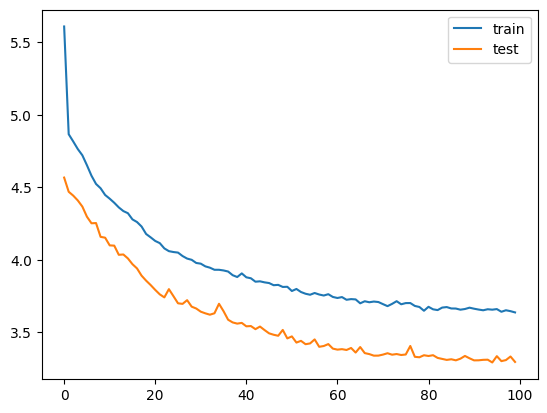

Estimator Category  D2 Score       MSE       MAE
0    Decision Tree Regressor      All  0.209207  3.197346  1.322448
1         Poisson Regression      All -0.002348  4.628923  1.676234
2                    XGBoost      All  0.310269  2.782876  1.153442
3        Neural Network(MLP)      All  0.190696  3.229451  1.353405
4                       LSTM      All  0.145627  3.985983  1.428775
5                        KNN      All  0.078029  4.325155  1.541819
6                        SVM      All  0.200431  3.533555  1.337125
7          Linear Regression      All  0.022118  4.464350  1.635320
8   Decision Tree Classifier      All  0.173988  4.709272  1.381346
9              Random Forest      All  0.277090  2.735175  1.208928
10         Gradient Boosting      All  0.288039  2.664728  1.190617
11          Voting Regressor      All  0.313267  2.589344  1.148429
12        Stacking Regressor      All  0.319604  2.546388  1.137831
13                       RNN      All  0.198865  3.295921  1.339744

<Figure size 640x480 with 0 Axes>

In [59]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

BATCH_SIZE = 100

# Reshape input to feed into RNN models [(batch_size, timesteps, input_dim)]
x_train_reshaped = x_train_scaled.reshape((x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))
x_test_reshaped = x_test_scaled.reshape((x_test_scaled.shape[0], 1, x_test_scaled.shape[1]))

model = tf.keras.Sequential()
# [timesteps, input_dim]
model.add(layers.SimpleRNN(64, input_shape=(x_train_reshaped.shape[1], x_train_reshaped.shape[2]), return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.SimpleRNN(64))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

history = model.fit(x_train_reshaped, y_train, epochs=100, batch_size=BATCH_SIZE, verbose=1, validation_data=(x_test_reshaped, y_test))

final_results.loc[len(final_results)] = [
    "RNN",
    "All",
    d2_absolute_error_score(y_test, model.predict(x_test_reshaped)),
    mean_squared_error(y_test, model.predict(x_test_reshaped)),
    mean_absolute_error(y_test, model.predict(x_test_reshaped))
]
# plot line chart of actual and predicted quantity in y axis and dt_range in x axis
fig = go.Figure()
fig.add_trace(go.Scatter(x=dt_range, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=dt_range, y=model.predict(x_test_reshaped), mode='lines', name='Predicted'))
fig.update_layout(title='RNN - All', xaxis_title='Date', yaxis_title='Quantity')
# make dir for rnn and delete if exists
if os.path.exists("results_org_data/rnn"):
    shutil.rmtree("results_org_data/rnn")
os.mkdir("results_org_data/rnn")
fig.write_html("results_org_data/rnn/all.html")
# fig.show()

# plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
plt.savefig('results_org_data/rnn/all_loss.png')

final_results

In [60]:
for sub_category in df['Sub-Category'].unique():
    this_df = df[df['Sub-Category'] == sub_category]
    this_x_train, this_x_test, this_y_train, this_y_test = train_test_split(this_df[x_labels], this_df['Quantity'], random_state=42)
    this_x_train_scaled = scaler.fit_transform(this_x_train)
    this_x_test_scaled = scaler.transform(this_x_test)
    this_x_train_reshaped = this_x_train_scaled.reshape((this_x_train_scaled.shape[0], 1, this_x_train_scaled.shape[1]))
    this_x_test_reshaped = this_x_test_scaled.reshape((this_x_test_scaled.shape[0], 1, this_x_test_scaled.shape[1]))
    this_model = tf.keras.Sequential()
    this_model.add(layers.SimpleRNN(64, input_shape=(this_x_train_reshaped.shape[1], this_x_train_reshaped.shape[2]), return_sequences=True))
    this_model.add(layers.Dropout(0.2))
    this_model.add(layers.SimpleRNN(64))
    this_model.add(layers.Dropout(0.2))
    this_model.add(layers.Dense(1))
    this_model.compile(loss='mean_squared_error', optimizer='adam')
    this_model.fit(this_x_train_reshaped, this_y_train, epochs=100, batch_size=BATCH_SIZE, verbose=1, validation_data=(this_x_test_reshaped, this_y_test))
    final_results_sub_cat.loc[len(final_results_sub_cat)] = [
        "RNN",
        decoded_sub_cat[int(sub_category)-1],
        d2_absolute_error_score(this_y_test, this_model.predict(this_x_test_reshaped)),
        mean_squared_error(this_y_test, this_model.predict(this_x_test_reshaped)),
        mean_absolute_error(this_y_test, this_model.predict(this_x_test_reshaped))
    ]
    # plot line chart of actual and predicted quantity in y axis and dt_range in x axis
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dt_range, y=this_y_test, mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=dt_range, y=this_model.predict(this_x_test_reshaped), mode='lines', name='Predicted'))
    fig.update_layout(title='RNN - ' + decoded_sub_cat[int(sub_category)-1], xaxis_title='Date', yaxis_title='Quantity')
    fig.write_html("results_org_data/rnn/" + decoded_sub_cat[int(sub_category)-1] + ".html")
    # fig.show()
    
final_results_sub_cat

Epoch 1/100


24/24 [==============================] - 1s 12ms/step - loss: 13.7008 - val_loss: 9.3735
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 6.3105 - val_loss: 5.3720
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 5.0058 - val_loss: 5.1574
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 4.7772 - val_loss: 5.0192
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 4.6537 - val_loss: 4.9130
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 4.6032 - val_loss: 4.8245
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 4.5307 - val_loss: 4.7527
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 4.4423 - val_loss: 4.6618
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 4.2886 - val_loss: 4.5864
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 4.2912 - val_loss: 4.5231
Epoch 11/100
24/24 

Estimator     Category  D2 Score       MSE       MAE
0    Decision Tree Regressor       Tables  0.197760  3.931450  1.405225
1    Decision Tree Regressor    Bookcases  0.166572  3.896300  1.406834
2    Decision Tree Regressor        Paper  0.253553  3.759862  1.298285
3    Decision Tree Regressor       Chairs  0.431711  2.152475  0.937268
4    Decision Tree Regressor     Supplies  0.167378  3.957430  1.437815
..                       ...          ...       ...       ...       ...
233                      RNN   Appliances  0.280035  2.836346  1.250652
234                      RNN     Machines  0.205656  3.219325  1.395711
235                      RNN      Copiers  0.294797  2.681647  1.208920
236                      RNN    Envelopes  0.439343  1.970627  0.954507
237                      RNN  Furnishings  0.470822  1.999657  0.969889

[238 rows x 5 columns]

# GRU

a sequential model using the Keras API in TensorFlow for a time series regression task. The model architecture is as follows:

The first layer added is a Bidirectional GRU (Gated Recurrent Unit) layer with 64 units. The Bidirectional wrapper allows the GRU layer to process the input sequence in both forward and backward directions. The input shape is defined based on the shape of the input data (x_train_reshaped), which is expected to have a time dimension (x_train_reshaped.shape[1]) and feature dimension (x_train_reshaped.shape[2]). Setting return_sequences=True indicates that the layer will return sequences instead of a single output.
The second layer is also a Bidirectional GRU layer with 64 units.
Finally, a dense layer with a single unit and ReLU activation function is added, representing the output layer.
The model is compiled using the 'mean_squared_error' loss function, which is commonly used for regression tasks. The Adam optimizer is used with a learning rate of 1e-4. Additionally, 'mean_squared_error' is specified as a metric to track during training.

In summary, this code constructs a sequential model with two Bidirectional GRU layers for processing time series data. The model aims to learn the underlying patterns in the input sequence and make predictions based on the learned representations. The ReLU activation function and mean squared error loss are used for the output layer.

2023-07-05 11:43:43.018386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:43:43.019908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:43:43.020852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 128)           27648     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                                 
 dense_36 (Dense)            (None, 1)                 129       
                                                                 
Total params: 102,273
Trainable params: 102,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2023-07-05 11:43:43.287434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:43:43.288547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:43:43.289693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

375/385 [============================>.] - ETA: 0s - loss: 9.6058 - mean_squared_error: 9.6058

2023-07-05 11:43:48.846697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:43:48.848218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:43:48.849184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

385/385 [==============================] - 6s 7ms/step - loss: 9.5011 - mean_squared_error: 9.5011 - val_loss: 5.4763 - val_mean_squared_error: 5.4763
Epoch 2/100
385/385 [==============================] - 2s 4ms/step - loss: 5.4097 - mean_squared_error: 5.4097 - val_loss: 5.1438 - val_mean_squared_error: 5.1438
Epoch 3/100
385/385 [==============================] - 2s 4ms/step - loss: 5.1359 - mean_squared_error: 5.1359 - val_loss: 4.8815 - val_mean_squared_error: 4.8815
Epoch 4/100
385/385 [==============================] - 2s 4ms/step - loss: 4.9583 - mean_squared_error: 4.9583 - val_loss: 4.7282 - val_mean_squared_error: 4.7282
Epoch 5/100
385/385 [==============================] - 2s 4ms/step - loss: 4.8663 - mean_squared_error: 4.8663 - val_loss: 4.6449 - val_mean_squared_error: 4.6449
Epoch 6/100
385/385 [==============================] - 2s 4ms/step - loss: 4.8240 - mean_squared_error: 4.8240 - val_loss: 4.6098 - val_mean_squared_error: 4.6098
Epoch 7/100
385/385 [=============

2023-07-05 11:46:38.894242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:46:38.895606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:46:38.896581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

401/401 [==============================] - 0s 1ms/step


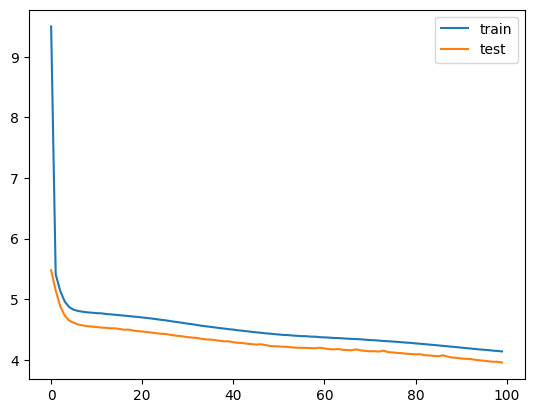

Estimator Category  D2 Score       MSE       MAE
0    Decision Tree Regressor      All  0.209207  3.197346  1.322448
1         Poisson Regression      All -0.002348  4.628923  1.676234
2                    XGBoost      All  0.310269  2.782876  1.153442
3        Neural Network(MLP)      All  0.190696  3.229451  1.353405
4                       LSTM      All  0.145627  3.985983  1.428775
5                        KNN      All  0.078029  4.325155  1.541819
6                        SVM      All  0.200431  3.533555  1.337125
7          Linear Regression      All  0.022118  4.464350  1.635320
8   Decision Tree Classifier      All  0.173988  4.709272  1.381346
9              Random Forest      All  0.277090  2.735175  1.208928
10         Gradient Boosting      All  0.288039  2.664728  1.190617
11          Voting Regressor      All  0.313267  2.589344  1.148429
12        Stacking Regressor      All  0.319604  2.546388  1.137831
13                       RNN      All  0.198865  3.295921  1.339744
14                       GRU      All  0.100307  3.955098  1.504564

<Figure size 640x480 with 0 Axes>

In [61]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, GRU, Embedding, Bidirectional, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint


scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

BATCH_SIZE = 100

# Reshape input to feed into GRU models [(batch_size, timesteps, input_dim)]
x_train_reshaped = x_train_scaled.reshape((x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))
x_test_reshaped = x_test_scaled.reshape((x_test_scaled.shape[0], 1, x_test_scaled.shape[1]))


model = Sequential()
model.add(Bidirectional(GRU(64, return_sequences=True), input_shape=(x_train_reshaped.shape[1], x_train_reshaped.shape[2])))
model.add(Bidirectional(GRU(64)))
model.add(Dense(1, activation='relu'))

model.compile(loss='mean_squared_error', optimizer=Adam(1e-4), metrics=['mean_squared_error'])
model.summary()

history = model.fit(x_train_reshaped, y_train, epochs=100, batch_size=BATCH_SIZE, verbose=1, validation_data=(x_test_reshaped, y_test))

final_results.loc[len(final_results)] = [
    "GRU",
    "All",
    d2_absolute_error_score(y_test, model.predict(x_test_reshaped)),
    mean_squared_error(y_test, model.predict(x_test_reshaped)),
    mean_absolute_error(y_test, model.predict(x_test_reshaped))
]

# plot line chart of actual and predicted quantity in y axis and dt_range in x axis
fig = go.Figure()
fig.add_trace(go.Scatter(x=dt_range, y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=dt_range, y=model.predict(x_test_reshaped), mode='lines', name='Predicted'))
fig.update_layout(title='GRU - All', xaxis_title='Date', yaxis_title='Quantity')
# make dir for gru and delete if exists
if os.path.exists("results_org_data/gru"):
    shutil.rmtree("results_org_data/gru")
os.makedirs("results_org_data/gru")
fig.write_html("results_org_data/gru/all.html")
# fig.show()

# plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
plt.savefig("results_org_data/gru/all_loss.png")

final_results

In [62]:
for sub_category in df['Sub-Category'].unique():
    this_df = df[df['Sub-Category'] == sub_category]
    this_x_train, this_x_test, this_y_train, this_y_test = train_test_split(this_df[x_labels], this_df['Quantity'], random_state=42)
    this_x_train_scaled = scaler.fit_transform(this_x_train)
    this_x_test_scaled = scaler.transform(this_x_test)
    this_x_train_reshaped = this_x_train_scaled.reshape((this_x_train_scaled.shape[0], 1, this_x_train_scaled.shape[1]))
    this_x_test_reshaped = this_x_test_scaled.reshape((this_x_test_scaled.shape[0], 1, this_x_test_scaled.shape[1]))
    this_model = Sequential()
    this_model.add(Bidirectional(GRU(64, return_sequences=True), input_shape=(this_x_train_reshaped.shape[1], this_x_train_reshaped.shape[2])))
    this_model.add(Bidirectional(GRU(64)))
    this_model.add(Dense(1, activation='relu'))
    this_model.compile(loss='mean_squared_error', optimizer=Adam(1e-4), metrics=['mean_squared_error'])
    this_model.fit(this_x_train_reshaped, this_y_train, epochs=100, batch_size=BATCH_SIZE, verbose=1, validation_data=(this_x_test_reshaped, this_y_test))
    final_results_sub_cat.loc[len(final_results_sub_cat)] = [
        "GRU",
        decoded_sub_cat[int(sub_category)-1],
        d2_absolute_error_score(this_y_test, this_model.predict(this_x_test_reshaped)),
        mean_squared_error(this_y_test, this_model.predict(this_x_test_reshaped)),
        mean_absolute_error(this_y_test, this_model.predict(this_x_test_reshaped))
    ]
    # plot line chart of actual and predicted quantity in y axis and dt_range in x axis
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dt_range, y=this_y_test, mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=dt_range, y=this_model.predict(this_x_test_reshaped), mode='lines', name='Predicted'))
    fig.update_layout(title='GRU - ' + decoded_sub_cat[int(sub_category)-1], xaxis_title='Date', yaxis_title='Quantity')
    fig.write_html("results_org_data/gru/" + decoded_sub_cat[int(sub_category)-1] + ".html")
    # fig.show()
    
final_results_sub_cat

2023-07-05 11:46:42.600486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:46:42.601928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:46:42.602883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-07-05 11:46:42.879318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:46:42.880936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:46:42.881894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/24 [===============>..............] - ETA: 0s - loss: 17.5745 - mean_squared_error: 17.5745  

2023-07-05 11:46:47.093651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:46:47.095010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:46:47.095890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

24/24 [==============================] - 5s 41ms/step - loss: 17.4179 - mean_squared_error: 17.4179 - val_loss: 18.0341 - val_mean_squared_error: 18.0341
Epoch 2/100
24/24 [==============================] - 0s 6ms/step - loss: 16.6635 - mean_squared_error: 16.6635 - val_loss: 17.2371 - val_mean_squared_error: 17.2371
Epoch 3/100
24/24 [==============================] - 0s 5ms/step - loss: 15.8493 - mean_squared_error: 15.8493 - val_loss: 16.3437 - val_mean_squared_error: 16.3437
Epoch 4/100
24/24 [==============================] - 0s 5ms/step - loss: 14.9207 - mean_squared_error: 14.9207 - val_loss: 15.3007 - val_mean_squared_error: 15.3007
Epoch 5/100
24/24 [==============================] - 0s 6ms/step - loss: 13.8200 - mean_squared_error: 13.8200 - val_loss: 14.0861 - val_mean_squared_error: 14.0861
Epoch 6/100
24/24 [==============================] - 0s 5ms/step - loss: 12.5618 - mean_squared_error: 12.5618 - val_loss: 12.7099 - val_mean_squared_error: 12.7099
Epoch 7/100
24/24 [==

2023-07-05 11:47:00.796069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:47:00.797603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:47:00.798483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 0s 2ms/step


2023-07-05 11:47:01.894121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:47:01.895564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:47:01.896698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-07-05 11:47:02.163842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:47:02.165312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:47:02.166305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/26 [===========================>..] - ETA: 0s - loss: 17.6041 - mean_squared_error: 17.6041

2023-07-05 11:47:07.042334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:47:07.043706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:47:07.044709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 5s 38ms/step - loss: 17.6897 - mean_squared_error: 17.6897 - val_loss: 17.3569 - val_mean_squared_error: 17.3569
Epoch 2/100
26/26 [==============================] - 0s 5ms/step - loss: 16.8972 - mean_squared_error: 16.8972 - val_loss: 16.5219 - val_mean_squared_error: 16.5219
Epoch 3/100
26/26 [==============================] - 0s 6ms/step - loss: 15.9999 - mean_squared_error: 15.9999 - val_loss: 15.5473 - val_mean_squared_error: 15.5473
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 14.9351 - mean_squared_error: 14.9351 - val_loss: 14.3616 - val_mean_squared_error: 14.3616
Epoch 5/100
26/26 [==============================] - 0s 5ms/step - loss: 13.6549 - mean_squared_error: 13.6549 - val_loss: 12.9439 - val_mean_squared_error: 12.9439
Epoch 6/100
26/26 [==============================] - 0s 5ms/step - loss: 12.1511 - mean_squared_error: 12.1511 - val_loss: 11.3439 - val_mean_squared_error: 11.3439
Epoch 7/100
26/26 [==

2023-07-05 11:47:21.671012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:47:21.672415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:47:21.673330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 0s 1ms/step


2023-07-05 11:47:22.763927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:47:22.765119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:47:22.766200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-07-05 11:47:23.031201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:47:23.032403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:47:23.033531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

24/26 [==========================>...] - ETA: 0s - loss: 16.9056 - mean_squared_error: 16.9056

2023-07-05 11:47:28.022059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:47:28.023549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:47:28.024435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 6s 39ms/step - loss: 16.9858 - mean_squared_error: 16.9858 - val_loss: 17.9028 - val_mean_squared_error: 17.9028
Epoch 2/100
26/26 [==============================] - 0s 5ms/step - loss: 16.1104 - mean_squared_error: 16.1104 - val_loss: 16.9454 - val_mean_squared_error: 16.9454
Epoch 3/100
26/26 [==============================] - 0s 6ms/step - loss: 15.1415 - mean_squared_error: 15.1415 - val_loss: 15.8637 - val_mean_squared_error: 15.8637
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 14.0198 - mean_squared_error: 14.0198 - val_loss: 14.5899 - val_mean_squared_error: 14.5899
Epoch 5/100
26/26 [==============================] - 0s 6ms/step - loss: 12.7155 - mean_squared_error: 12.7155 - val_loss: 13.1133 - val_mean_squared_error: 13.1133
Epoch 6/100
26/26 [==============================] - 0s 5ms/step - loss: 11.2329 - mean_squared_error: 11.2329 - val_loss: 11.4695 - val_mean_squared_error: 11.4695
Epoch 7/100
26/26 [==

2023-07-05 11:47:42.886020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:47:42.887409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:47:42.888289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 0s 1ms/step


2023-07-05 11:47:43.991496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:47:43.992697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:47:43.993912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-07-05 11:47:44.259761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:47:44.260978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:47:44.262212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/17 [=====================>........] - ETA: 0s - loss: 15.6092 - mean_squared_error: 15.6092  

2023-07-05 11:47:48.422588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:47:48.423982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:47:48.424906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

17/17 [==============================] - 5s 57ms/step - loss: 15.6971 - mean_squared_error: 15.6971 - val_loss: 16.4694 - val_mean_squared_error: 16.4694
Epoch 2/100
17/17 [==============================] - 0s 6ms/step - loss: 15.6971 - mean_squared_error: 15.6971 - val_loss: 16.4694 - val_mean_squared_error: 16.4694
Epoch 3/100
17/17 [==============================] - 0s 6ms/step - loss: 15.6971 - mean_squared_error: 15.6971 - val_loss: 16.4694 - val_mean_squared_error: 16.4694
Epoch 4/100
17/17 [==============================] - 0s 6ms/step - loss: 15.6971 - mean_squared_error: 15.6971 - val_loss: 16.4694 - val_mean_squared_error: 16.4694
Epoch 5/100
17/17 [==============================] - 0s 6ms/step - loss: 15.6971 - mean_squared_error: 15.6971 - val_loss: 16.4694 - val_mean_squared_error: 16.4694
Epoch 6/100
17/17 [==============================] - 0s 6ms/step - loss: 15.6971 - mean_squared_error: 15.6971 - val_loss: 16.4694 - val_mean_squared_error: 16.4694
Epoch 7/100
17/17 [==

2023-07-05 11:47:59.111213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:47:59.112556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:47:59.113400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

18/18 [==============================] - 0s 1ms/step


2023-07-05 11:48:00.150211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:48:00.151635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:48:00.152541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-07-05 11:48:01.189818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-07-05 11:48:01.217617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:48:01.218671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

1/7 [===>..........................] - ETA: 22s - loss: 15.4601 - mean_squared_error: 15.4601

2023-07-05 11:48:05.285115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:48:05.286679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:48:05.287632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 5s 143ms/step - loss: 17.5689 - mean_squared_error: 17.5689 - val_loss: 18.0330 - val_mean_squared_error: 18.0330
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 17.3316 - mean_squared_error: 17.3316 - val_loss: 17.7843 - val_mean_squared_error: 17.7843
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 17.0807 - mean_squared_error: 17.0807 - val_loss: 17.5367 - val_mean_squared_error: 17.5367
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 16.8387 - mean_squared_error: 16.8387 - val_loss: 17.2840 - val_mean_squared_error: 17.2840
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 16.5904 - mean_squared_error: 16.5904 - val_loss: 17.0277 - val_mean_squared_error: 17.0277
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 16.3341 - mean_squared_error: 16.3341 - val_loss: 16.7647 - val_mean_squared_error: 16.7647
Epoch 7/100
7/7 [===============

2023-07-05 11:48:11.570062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:48:11.571565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:48:11.572453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 1ms/step


2023-07-05 11:48:12.544721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:48:12.546130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:48:12.547030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-07-05 11:48:12.813621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:48:12.815037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:48:12.815993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/47 [=======================>......] - ETA: 0s - loss: 16.3390 - mean_squared_error: 16.3390

2023-07-05 11:48:17.870303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:48:17.871855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:48:17.872850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

47/47 [==============================] - 6s 23ms/step - loss: 16.2631 - mean_squared_error: 16.2631 - val_loss: 17.5652 - val_mean_squared_error: 17.5652
Epoch 2/100
47/47 [==============================] - 0s 6ms/step - loss: 14.9092 - mean_squared_error: 14.9092 - val_loss: 15.9144 - val_mean_squared_error: 15.9144
Epoch 3/100
47/47 [==============================] - 0s 6ms/step - loss: 13.0448 - mean_squared_error: 13.0448 - val_loss: 13.6209 - val_mean_squared_error: 13.6209
Epoch 4/100
47/47 [==============================] - 0s 5ms/step - loss: 10.6201 - mean_squared_error: 10.6201 - val_loss: 10.8661 - val_mean_squared_error: 10.8661
Epoch 5/100
47/47 [==============================] - 0s 5ms/step - loss: 8.0803 - mean_squared_error: 8.0803 - val_loss: 8.3551 - val_mean_squared_error: 8.3551
Epoch 6/100
47/47 [==============================] - 0s 5ms/step - loss: 6.2843 - mean_squared_error: 6.2843 - val_loss: 6.9392 - val_mean_squared_error: 6.9392
Epoch 7/100
47/47 [==========

2023-07-05 11:48:42.150261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:48:42.151744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:48:42.152706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

49/49 [==============================] - 0s 1ms/step


2023-07-05 11:48:43.390785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:48:43.392356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:48:43.393312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-07-05 11:48:43.663203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:48:43.664625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:48:43.665711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/19 [===================>..........] - ETA: 0s - loss: 16.8815 - mean_squared_error: 16.8815  

2023-07-05 11:48:47.861967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:48:47.863252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:48:47.864147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 5s 51ms/step - loss: 17.7178 - mean_squared_error: 17.7178 - val_loss: 17.7463 - val_mean_squared_error: 17.7463
Epoch 2/100
19/19 [==============================] - 0s 6ms/step - loss: 17.7178 - mean_squared_error: 17.7178 - val_loss: 17.7463 - val_mean_squared_error: 17.7463
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 17.7178 - mean_squared_error: 17.7178 - val_loss: 17.7463 - val_mean_squared_error: 17.7463
Epoch 4/100
19/19 [==============================] - 0s 6ms/step - loss: 17.7178 - mean_squared_error: 17.7178 - val_loss: 17.7463 - val_mean_squared_error: 17.7463
Epoch 5/100
19/19 [==============================] - 0s 6ms/step - loss: 17.7178 - mean_squared_error: 17.7178 - val_loss: 17.7463 - val_mean_squared_error: 17.7463
Epoch 6/100
19/19 [==============================] - 0s 6ms/step - loss: 17.7178 - mean_squared_error: 17.7178 - val_loss: 17.7463 - val_mean_squared_error: 17.7463
Epoch 7/100
19/19 [==

2023-07-05 11:48:59.522960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:48:59.524408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:48:59.525272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 0s 1ms/step


2023-07-05 11:49:00.549541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:49:00.550967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:49:00.552096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-07-05 11:49:01.617195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-07-05 11:49:01.646013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:49:01.646943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

12/14 [========================>.....] - ETA: 0s - loss: 17.5511 - mean_squared_error: 17.5511 

2023-07-05 11:49:05.810604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:49:05.811830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:49:05.812798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

14/14 [==============================] - 5s 69ms/step - loss: 17.4187 - mean_squared_error: 17.4187 - val_loss: 15.3047 - val_mean_squared_error: 15.3047
Epoch 2/100
14/14 [==============================] - 0s 6ms/step - loss: 17.0963 - mean_squared_error: 17.0963 - val_loss: 14.9750 - val_mean_squared_error: 14.9750
Epoch 3/100
14/14 [==============================] - 0s 6ms/step - loss: 16.7347 - mean_squared_error: 16.7347 - val_loss: 14.6311 - val_mean_squared_error: 14.6311
Epoch 4/100
14/14 [==============================] - 0s 6ms/step - loss: 16.3518 - mean_squared_error: 16.3518 - val_loss: 14.2650 - val_mean_squared_error: 14.2650
Epoch 5/100
14/14 [==============================] - 0s 6ms/step - loss: 15.9422 - mean_squared_error: 15.9422 - val_loss: 13.8646 - val_mean_squared_error: 13.8646
Epoch 6/100
14/14 [==============================] - 0s 6ms/step - loss: 15.4866 - mean_squared_error: 15.4866 - val_loss: 13.4242 - val_mean_squared_error: 13.4242
Epoch 7/100
14/14 [==

2023-07-05 11:49:15.187458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:49:15.188927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:49:15.189926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

14/14 [==============================] - 0s 1ms/step


2023-07-05 11:49:16.199489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:49:16.200905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:49:16.201898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-07-05 11:49:16.461177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:49:16.463497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:49:16.464485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/12 [=>............................] - ETA: 50s - loss: 15.8827 - mean_squared_error: 15.8827

2023-07-05 11:49:21.486430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:49:21.487911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:49:21.488859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 6s 82ms/step - loss: 16.0520 - mean_squared_error: 16.0520 - val_loss: 14.5212 - val_mean_squared_error: 14.5212
Epoch 2/100
12/12 [==============================] - 0s 6ms/step - loss: 15.6655 - mean_squared_error: 15.6655 - val_loss: 14.1457 - val_mean_squared_error: 14.1457
Epoch 3/100
12/12 [==============================] - 0s 7ms/step - loss: 15.2759 - mean_squared_error: 15.2759 - val_loss: 13.7615 - val_mean_squared_error: 13.7615
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 14.8720 - mean_squared_error: 14.8720 - val_loss: 13.3634 - val_mean_squared_error: 13.3634
Epoch 5/100
12/12 [==============================] - 0s 9ms/step - loss: 14.4532 - mean_squared_error: 14.4532 - val_loss: 12.9442 - val_mean_squared_error: 12.9442
Epoch 6/100
12/12 [==============================] - 0s 7ms/step - loss: 14.0099 - mean_squared_error: 14.0099 - val_loss: 12.4986 - val_mean_squared_error: 12.4986
Epoch 7/100
12/12 [==

2023-07-05 11:49:30.061023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:49:30.062847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:49:30.064018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 0s 2ms/step


2023-07-05 11:49:31.164468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:49:31.166114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:49:31.167029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-07-05 11:49:31.790154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:49:31.792163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:49:31.793326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/19 [==============>...............] - ETA: 0s - loss: 15.7278 - mean_squared_error: 15.7278  

2023-07-05 11:49:35.918532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:49:35.920029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:49:35.921491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 5s 58ms/step - loss: 16.2850 - mean_squared_error: 16.2850 - val_loss: 15.4171 - val_mean_squared_error: 15.4171
Epoch 2/100
19/19 [==============================] - 0s 6ms/step - loss: 15.7643 - mean_squared_error: 15.7643 - val_loss: 14.8953 - val_mean_squared_error: 14.8953
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 15.2025 - mean_squared_error: 15.2025 - val_loss: 14.3272 - val_mean_squared_error: 14.3272
Epoch 4/100
19/19 [==============================] - 0s 6ms/step - loss: 14.5782 - mean_squared_error: 14.5782 - val_loss: 13.6797 - val_mean_squared_error: 13.6797
Epoch 5/100
19/19 [==============================] - 0s 6ms/step - loss: 13.8695 - mean_squared_error: 13.8695 - val_loss: 12.9379 - val_mean_squared_error: 12.9379
Epoch 6/100
19/19 [==============================] - 0s 6ms/step - loss: 13.0522 - mean_squared_error: 13.0522 - val_loss: 12.1055 - val_mean_squared_error: 12.1055
Epoch 7/100
19/19 [==

2023-07-05 11:49:47.731424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:49:47.732789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:49:47.733637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 0s 1ms/step


2023-07-05 11:49:48.781153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:49:48.782699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:49:48.783578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-07-05 11:49:49.844244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-07-05 11:49:49.871912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:49:49.872915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

26/38 [===================>..........] - ETA: 0s - loss: 15.3655 - mean_squared_error: 15.3655

2023-07-05 11:49:54.077438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:49:54.078919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:49:54.079876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 [==============================] - 5s 28ms/step - loss: 15.4135 - mean_squared_error: 15.4135 - val_loss: 15.7796 - val_mean_squared_error: 15.7796
Epoch 2/100
38/38 [==============================] - 0s 5ms/step - loss: 14.2828 - mean_squared_error: 14.2828 - val_loss: 14.4947 - val_mean_squared_error: 14.4947
Epoch 3/100
38/38 [==============================] - 0s 5ms/step - loss: 12.9008 - mean_squared_error: 12.9008 - val_loss: 12.8582 - val_mean_squared_error: 12.8582
Epoch 4/100
38/38 [==============================] - 0s 5ms/step - loss: 11.1443 - mean_squared_error: 11.1443 - val_loss: 10.8314 - val_mean_squared_error: 10.8314
Epoch 5/100
38/38 [==============================] - 0s 5ms/step - loss: 9.0910 - mean_squared_error: 9.0910 - val_loss: 8.5899 - val_mean_squared_error: 8.5899
Epoch 6/100
38/38 [==============================] - 0s 5ms/step - loss: 7.0660 - mean_squared_error: 7.0660 - val_loss: 6.6178 - val_mean_squared_error: 6.6178
Epoch 7/100
38/38 [==========

2023-07-05 11:50:14.096087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:50:14.097744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:50:14.098680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

40/40 [==============================] - 0s 1ms/step


2023-07-05 11:50:15.272176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:50:15.273607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:50:15.274545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-07-05 11:50:15.536776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:50:15.538014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:50:15.538831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/24 [===============>..............] - ETA: 0s - loss: 17.1492 - mean_squared_error: 17.1492  

2023-07-05 11:50:20.518598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:50:20.520159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:50:20.521019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

24/24 [==============================] - 6s 42ms/step - loss: 17.3399 - mean_squared_error: 17.3399 - val_loss: 18.9357 - val_mean_squared_error: 18.9357
Epoch 2/100
24/24 [==============================] - 0s 6ms/step - loss: 17.3399 - mean_squared_error: 17.3399 - val_loss: 18.9357 - val_mean_squared_error: 18.9357
Epoch 3/100
24/24 [==============================] - 0s 5ms/step - loss: 17.3399 - mean_squared_error: 17.3399 - val_loss: 18.9357 - val_mean_squared_error: 18.9357
Epoch 4/100
24/24 [==============================] - 0s 6ms/step - loss: 17.3399 - mean_squared_error: 17.3399 - val_loss: 18.9357 - val_mean_squared_error: 18.9357
Epoch 5/100
24/24 [==============================] - 0s 6ms/step - loss: 17.3399 - mean_squared_error: 17.3399 - val_loss: 18.9357 - val_mean_squared_error: 18.9357
Epoch 6/100
24/24 [==============================] - 0s 5ms/step - loss: 17.3399 - mean_squared_error: 17.3399 - val_loss: 18.9357 - val_mean_squared_error: 18.9357
Epoch 7/100
24/24 [==

2023-07-05 11:50:34.627243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:50:34.628504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:50:34.629420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 0s 1ms/step


2023-07-05 11:50:35.729085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:50:35.730499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:50:35.731463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-07-05 11:50:36.003010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:50:36.004181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:50:36.005244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

37/37 [==============================] - ETA: 0s - loss: 15.4543 - mean_squared_error: 15.4543

2023-07-05 11:50:40.256513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:50:40.258037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:50:40.259047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

37/37 [==============================] - 5s 28ms/step - loss: 15.4543 - mean_squared_error: 15.4543 - val_loss: 15.6961 - val_mean_squared_error: 15.6961
Epoch 2/100
37/37 [==============================] - 0s 5ms/step - loss: 14.3036 - mean_squared_error: 14.3036 - val_loss: 14.4136 - val_mean_squared_error: 14.4136
Epoch 3/100
37/37 [==============================] - 0s 6ms/step - loss: 12.9272 - mean_squared_error: 12.9272 - val_loss: 12.8062 - val_mean_squared_error: 12.8062
Epoch 4/100
37/37 [==============================] - 0s 5ms/step - loss: 11.2323 - mean_squared_error: 11.2323 - val_loss: 10.8816 - val_mean_squared_error: 10.8816
Epoch 5/100
37/37 [==============================] - 0s 5ms/step - loss: 9.2956 - mean_squared_error: 9.2956 - val_loss: 8.8060 - val_mean_squared_error: 8.8060
Epoch 6/100
37/37 [==============================] - 0s 5ms/step - loss: 7.3959 - mean_squared_error: 7.3959 - val_loss: 6.9640 - val_mean_squared_error: 6.9640
Epoch 7/100
37/37 [==========

2023-07-05 11:50:59.963721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:50:59.965120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:50:59.966072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 0s 1ms/step


2023-07-05 11:51:01.666508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:51:01.668096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:51:01.669113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-07-05 11:51:01.954245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:51:01.955797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:51:01.956756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - ETA: 0s - loss: 17.6751 - mean_squared_error: 17.6751

2023-07-05 11:51:06.282882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:51:06.284336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:51:06.285259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 5s 37ms/step - loss: 17.6751 - mean_squared_error: 17.6751 - val_loss: 18.6812 - val_mean_squared_error: 18.6812
Epoch 2/100
27/27 [==============================] - 0s 6ms/step - loss: 16.9566 - mean_squared_error: 16.9566 - val_loss: 17.8651 - val_mean_squared_error: 17.8651
Epoch 3/100
27/27 [==============================] - 0s 5ms/step - loss: 16.1128 - mean_squared_error: 16.1128 - val_loss: 16.8727 - val_mean_squared_error: 16.8727
Epoch 4/100
27/27 [==============================] - 0s 5ms/step - loss: 15.0707 - mean_squared_error: 15.0707 - val_loss: 15.6280 - val_mean_squared_error: 15.6280
Epoch 5/100
27/27 [==============================] - 0s 5ms/step - loss: 13.7886 - mean_squared_error: 13.7886 - val_loss: 14.0989 - val_mean_squared_error: 14.0989
Epoch 6/100
27/27 [==============================] - 0s 6ms/step - loss: 12.2427 - mean_squared_error: 12.2427 - val_loss: 12.3356 - val_mean_squared_error: 12.3356
Epoch 7/100
27/27 [==

2023-07-05 11:51:21.546446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:51:21.547917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:51:21.548839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 [==============================] - 0s 1ms/step


2023-07-05 11:51:22.632654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:51:22.634097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:51:22.634960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-07-05 11:51:22.894685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:51:22.896203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:51:22.897171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/19 [===================>..........] - ETA: 0s - loss: 16.4115 - mean_squared_error: 16.4115  

2023-07-05 11:51:27.965639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:51:27.967007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:51:27.968044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 6s 53ms/step - loss: 16.4216 - mean_squared_error: 16.4216 - val_loss: 18.0024 - val_mean_squared_error: 18.0024
Epoch 2/100
19/19 [==============================] - 0s 6ms/step - loss: 16.0355 - mean_squared_error: 16.0355 - val_loss: 17.4597 - val_mean_squared_error: 17.4597
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 15.5112 - mean_squared_error: 15.5112 - val_loss: 16.8895 - val_mean_squared_error: 16.8895
Epoch 4/100
19/19 [==============================] - 0s 7ms/step - loss: 14.9518 - mean_squared_error: 14.9518 - val_loss: 16.2556 - val_mean_squared_error: 16.2556
Epoch 5/100
19/19 [==============================] - 0s 6ms/step - loss: 14.3194 - mean_squared_error: 14.3194 - val_loss: 15.5180 - val_mean_squared_error: 15.5180
Epoch 6/100
19/19 [==============================] - 0s 6ms/step - loss: 13.5820 - mean_squared_error: 13.5820 - val_loss: 14.6631 - val_mean_squared_error: 14.6631
Epoch 7/100
19/19 [==

2023-07-05 11:51:39.758192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:51:39.759629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:51:39.760556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

20/20 [==============================] - 0s 1ms/step


2023-07-05 11:51:40.820927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:51:40.822312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:51:40.823263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-07-05 11:51:41.092698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:51:41.093902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:51:41.095023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

14/19 [=====================>........] - ETA: 0s - loss: 16.7412 - mean_squared_error: 16.7412  

2023-07-05 11:51:45.221147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:51:45.222533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:51:45.223463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 5s 50ms/step - loss: 16.4450 - mean_squared_error: 16.4450 - val_loss: 17.6644 - val_mean_squared_error: 17.6644
Epoch 2/100
19/19 [==============================] - 0s 6ms/step - loss: 15.9500 - mean_squared_error: 15.9500 - val_loss: 17.1344 - val_mean_squared_error: 17.1344
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 15.4306 - mean_squared_error: 15.4306 - val_loss: 16.5486 - val_mean_squared_error: 16.5486
Epoch 4/100
19/19 [==============================] - 0s 6ms/step - loss: 14.8395 - mean_squared_error: 14.8395 - val_loss: 15.8872 - val_mean_squared_error: 15.8872
Epoch 5/100
19/19 [==============================] - 0s 6ms/step - loss: 14.1680 - mean_squared_error: 14.1680 - val_loss: 15.1064 - val_mean_squared_error: 15.1064
Epoch 6/100
19/19 [==============================] - 0s 6ms/step - loss: 13.3850 - mean_squared_error: 13.3850 - val_loss: 14.2151 - val_mean_squared_error: 14.2151
Epoch 7/100
19/19 [==

2023-07-05 11:51:56.792027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:51:56.793208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:51:56.794440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 0s 1ms/step


2023-07-05 11:51:57.811643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:51:57.813026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:51:57.813959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-07-05 11:51:58.073687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:51:58.075200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:51:58.076119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/20 [==================>...........] - ETA: 0s - loss: 17.6291 - mean_squared_error: 17.6291  

2023-07-05 11:52:03.054268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:52:03.055670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:52:03.056683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

20/20 [==============================] - 5s 49ms/step - loss: 17.9059 - mean_squared_error: 17.9059 - val_loss: 18.6608 - val_mean_squared_error: 18.6608
Epoch 2/100
20/20 [==============================] - 0s 6ms/step - loss: 17.5392 - mean_squared_error: 17.5392 - val_loss: 18.2454 - val_mean_squared_error: 18.2454
Epoch 3/100
20/20 [==============================] - 0s 6ms/step - loss: 17.1088 - mean_squared_error: 17.1088 - val_loss: 17.7802 - val_mean_squared_error: 17.7802
Epoch 4/100
20/20 [==============================] - 0s 6ms/step - loss: 16.6140 - mean_squared_error: 16.6140 - val_loss: 17.2349 - val_mean_squared_error: 17.2349
Epoch 5/100
20/20 [==============================] - 0s 6ms/step - loss: 16.0185 - mean_squared_error: 16.0185 - val_loss: 16.5820 - val_mean_squared_error: 16.5820
Epoch 6/100
20/20 [==============================] - 0s 6ms/step - loss: 15.3099 - mean_squared_error: 15.3099 - val_loss: 15.7915 - val_mean_squared_error: 15.7915
Epoch 7/100
20/20 [==

2023-07-05 11:52:15.097772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 11:52:15.099252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 11:52:15.100228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - 0s 1ms/step


Estimator     Category  D2 Score       MSE       MAE
0    Decision Tree Regressor       Tables  0.197760  3.931450  1.405225
1    Decision Tree Regressor    Bookcases  0.166572  3.896300  1.406834
2    Decision Tree Regressor        Paper  0.253553  3.759862  1.298285
3    Decision Tree Regressor       Chairs  0.431711  2.152475  0.937268
4    Decision Tree Regressor     Supplies  0.167378  3.957430  1.437815
..                       ...          ...       ...       ...       ...
250                      GRU   Appliances  0.228458  3.096924  1.340247
251                      GRU     Machines  0.181846  3.520673  1.437547
252                      GRU      Copiers  0.228641  3.059414  1.322330
253                      GRU    Envelopes  0.378058  2.212972  1.058843
254                      GRU  Furnishings  0.199335  3.695191  1.467476

[255 rows x 5 columns]

In [63]:
# save results
final_results.to_csv('results_org_data/results.csv', index=False)
final_results_sub_cat.to_csv('results_org_data/results_sub_cat.csv', index=False)